In [1072]:
from collections import Counter
from math import isnan, log
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, entropy, kstest, ks_2samp, shapiro, ttest_ind
from typing import Any, Callable, Dict, Iterable, List, Set, TextIO, Union
from typing import _UnionGenericAlias as Alias

import datawig
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
import xgboost

In [257]:
warnings.filterwarnings('ignore')

In [8]:
os.chdir(os.path.join(os.path.expanduser('~'), 'HackFGR'))

In [180]:
numeric: Alias = Union[int, float]

# Uploading the autopsy-based dataset

In [286]:
with open(os.path.join('data', 'raw', 'source.csv'), 'r') as h:
    source_raw: pd.core.frame.DataFrame = pd.read_csv(
        h,
        header=0,
        index_col=0,
        sep=','
    )

## Factorizing the categorical variables

In [287]:
for col in ['age', 'gender', 'FGR', 'gestation', 'infection', 'stage']:
    source_raw[col] = pd.Categorical(source_raw[col])

## Checking for row-wise duplicates

In [73]:
print(f'Index length is {source_raw.index.shape[0]}, number of unique indices is {source_raw.index.nunique()}')

Index length is 3270, number of unique indices is 3269


In [68]:
[source_raw.index[x] for x in range(source_raw.index.shape[0]) if source_raw.index.duplicated()[x]]

['m2011_687']

In [74]:
source_raw.loc['m2011_687',:]

,gender,age,gestation,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,kidney,thymus,adrenal,pancreas,PlacentaWeight,infection,FGR,stage
id,,,,,,,,,,,,,,,,,,
m2011_687,1,0,23,31.0,650,96.0,4.6,18.8,33.2,0.7,6.0,1.9,1.8,1.1,150.0,no,0,canalicular
m2011_687,1,0,23,32.0,650,96.0,4.6,18.8,33.2,0.7,6.0,1.9,1.8,1.1,150.0,no,0,canalicular


In [288]:
source_raw = source_raw[~source_raw.index.duplicated(keep='first')]

In [76]:
source_raw.shape

(3269, 18)

## Describing the resulting data

In [289]:
source_raw.describe()

,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,kidney,thymus,adrenal,pancreas,PlacentaWeight
count,3269.000000,3269.000000,3222.000000,3264.000000,3267.000000,3260.000000,3249.000000,3258.000000,3237.000000,3195.000000,2500.000000,2759.000000
mean,36.807892,1336.587947,173.291431,8.563519,29.914120,60.720064,3.816639,12.234316,4.462874,3.864249,1.706274,234.408336
std,8.591716,1084.715466,120.296188,6.411458,21.396194,49.960384,4.298991,8.934970,4.869423,3.154018,1.441454,120.387495
min,15.000000,71.000000,9.910000,0.890000,4.000000,2.000000,0.100000,0.800000,0.100000,0.100000,0.100000,10.000000
25%,31.000000,600.000000,89.000000,4.200000,16.100000,28.287500,1.100000,6.200000,1.400000,1.900000,0.727500,150.000000
50%,33.000000,790.000000,116.000000,5.600000,20.700000,37.000000,1.800000,8.200000,2.200000,2.500000,1.000000,200.000000
75%,43.000000,1890.000000,250.000000,11.612500,38.350000,76.000000,5.100000,16.575000,5.700000,4.700000,2.200000,300.000000
max,59.000000,5000.000000,560.000000,35.500000,141.000000,285.000000,27.300000,48.500000,38.700000,22.400000,8.700000,1010.000000


## Plotting the key variables' distributions and assessing their normality

In [291]:
for column in source_raw.columns:
    if pd.api.types.is_numeric_dtype(source_raw[column]):
        ks_stat, ks_pval = kstest(source_raw[column], 'norm')
        shap_stat, shap_pval = shapiro(source_raw[column])
        print(f'For column {column}, Kolmogorov-Smirnov stat is {ks_stat} (p-value is {ks_pval}), Shapiro-Wilk stat is {shap_stat} (p-value is {shap_pval})')

For column BodyLength, Kolmogorov-Smirnov stat is 1.0 (p-value is 0.0), Shapiro-Wilk stat is 0.8767854571342468 (p-value is 4.203895392974451e-45)
For column BodyWeight, Kolmogorov-Smirnov stat is 1.0 (p-value is 0.0), Shapiro-Wilk stat is 0.7659764885902405 (p-value is 0.0)
For column brain, Kolmogorov-Smirnov stat is nan (p-value is nan), Shapiro-Wilk stat is nan (p-value is 1.0)
For column heart, Kolmogorov-Smirnov stat is nan (p-value is nan), Shapiro-Wilk stat is nan (p-value is 1.0)
For column lung, Kolmogorov-Smirnov stat is nan (p-value is nan), Shapiro-Wilk stat is nan (p-value is 1.0)
For column liver, Kolmogorov-Smirnov stat is nan (p-value is nan), Shapiro-Wilk stat is nan (p-value is 1.0)
For column spleen, Kolmogorov-Smirnov stat is nan (p-value is nan), Shapiro-Wilk stat is nan (p-value is 1.0)
For column kidney, Kolmogorov-Smirnov stat is nan (p-value is nan), Shapiro-Wilk stat is nan (p-value is 1.0)
For column thymus, Kolmogorov-Smirnov stat is nan (p-value is nan), S

### Probability densities for length and weight, bulk data

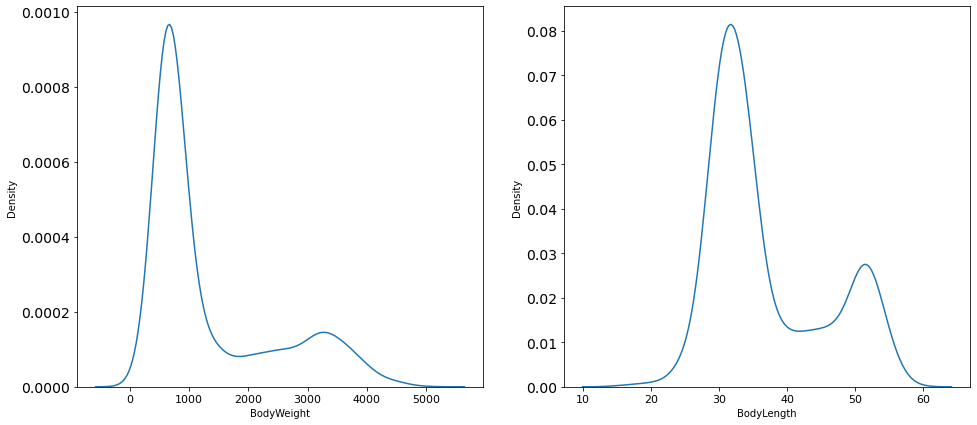

In [92]:
matplotlib.rcParams['figure.figsize'] = [16, 7]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False)
sns.kdeplot(
    data=source_raw,
    x='BodyWeight',
    ax=ax1
)
sns.kdeplot(
    data=source_raw,
    x='BodyLength',
    ax=ax2
)
plt.show()

### Probability densities for length and weight, genderwise

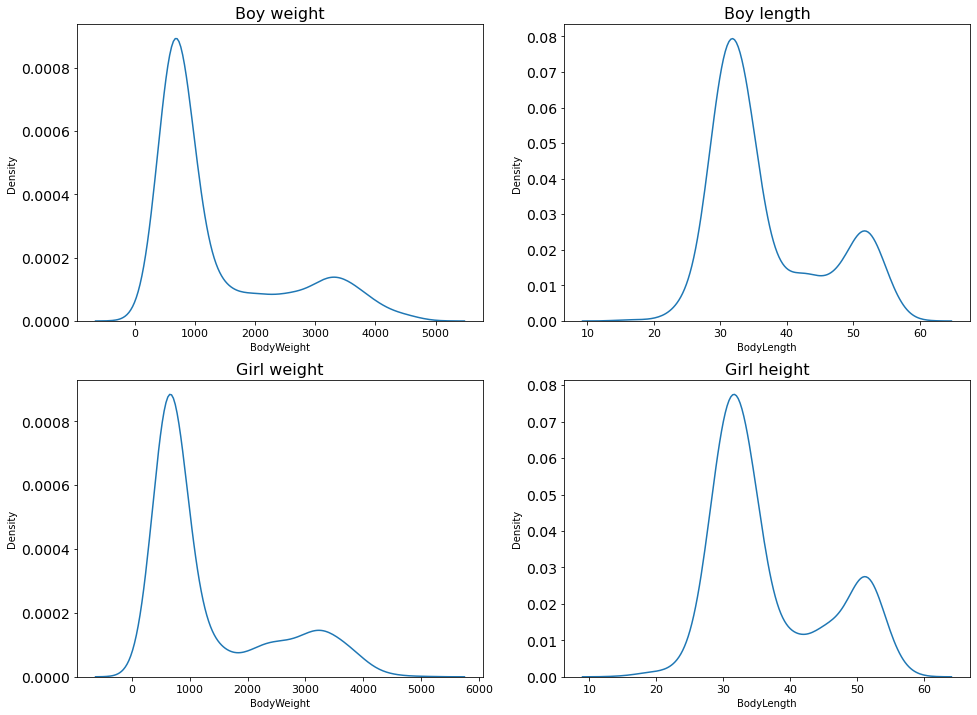

In [99]:
matplotlib.rcParams['figure.figsize'] = [16, 12]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False)
bw = sns.kdeplot(
    data=source_raw[source_raw.gender == 1],
    x='BodyWeight',
    ax=axs[0][0]
)
bw.set_title('Boy weight', size=16)
bl = sns.kdeplot(
    data=source_raw[source_raw.gender == 1],
    x='BodyLength',
    ax=axs[0][1],
)
bl.set_title('Boy length', size=16)
gw = sns.kdeplot(
    data=source_raw[source_raw.gender == 2],
    x='BodyWeight',
    ax=axs[1][0]
)
gw.set_title('Girl weight', size=16)
gl = sns.kdeplot(
    data=source_raw[source_raw.gender == 2],
    x='BodyLength',
    ax=axs[1][1],
)
gl.set_title('Girl height', size=16)
plt.show()

### Length and weight distribution, gender- and weekwise

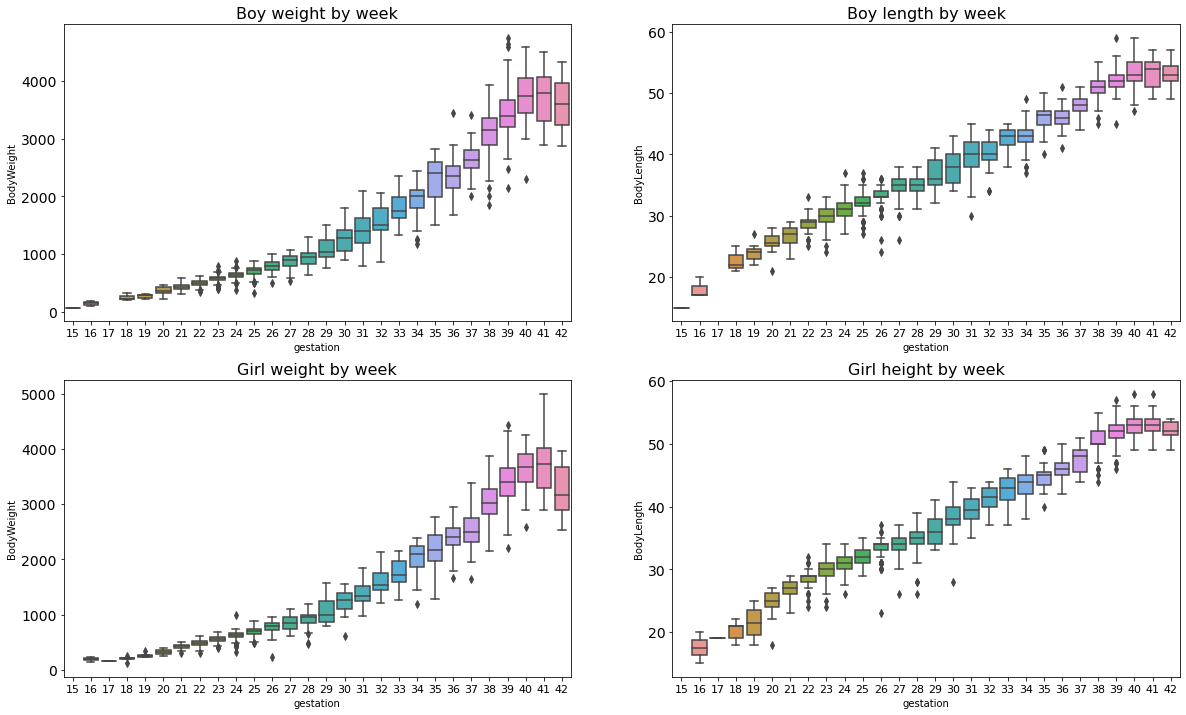

In [ ]:
matplotlib.rcParams['figure.figsize'] = [20, 12]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False)
bw = sns.boxplot(
    data=source_raw[source_raw.gender == 1],
    x='gestation',
    y='BodyWeight',
    ax=axs[0][0]
)
bw.set_title('Boy weight by week', size=16)
bl = sns.boxplot(
    data=source_raw[source_raw.gender == 1],
    x='gestation',
    y='BodyLength',
    ax=axs[0][1],
)
bl.set_title('Boy length by week', size=16)
gw = sns.boxplot(
    data=source_raw[source_raw.gender == 2],
    x='gestation',
    y='BodyWeight',
    ax=axs[1][0]
)
gw.set_title('Girl weight by week', size=16)
gl = sns.boxplot(
    data=source_raw[source_raw.gender == 2],
    x='gestation',
    y='BodyLength',
    ax=axs[1][1],
)
gl.set_title('Girl height by week', size=16)
plt.show()

### Weight vs length, colored by FGR status

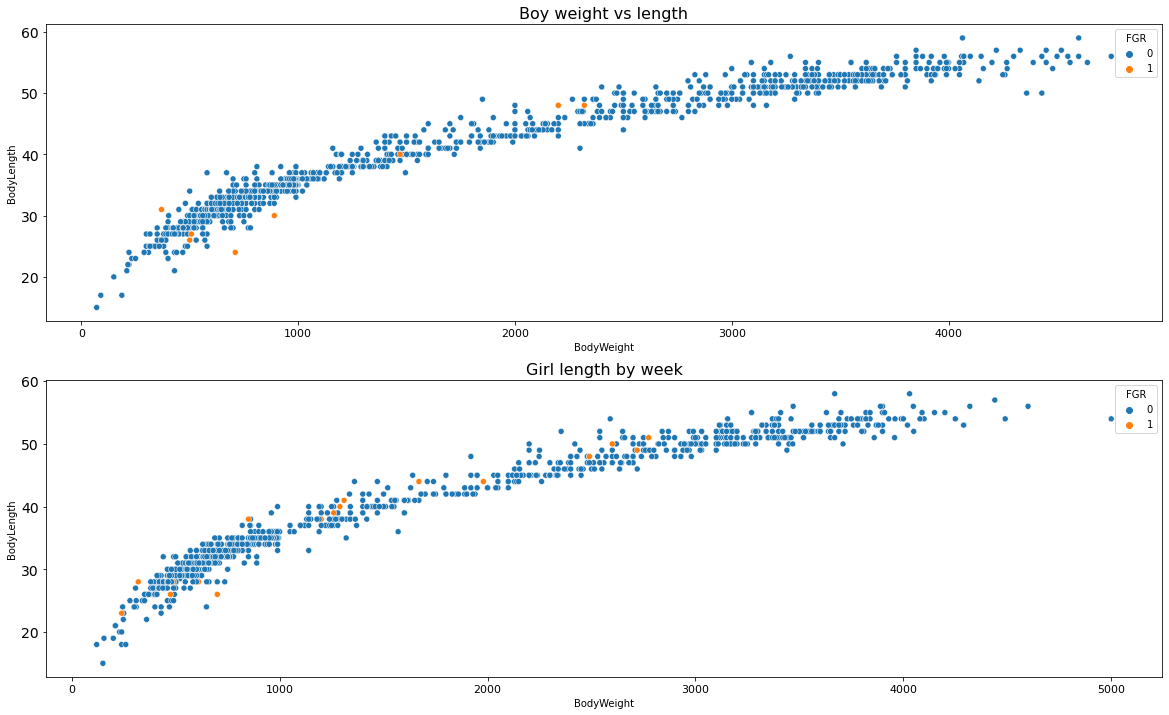

In [139]:
matplotlib.rcParams['figure.figsize'] = [20, 12]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, axs = plt.subplots(2,1, sharex=False, sharey=False)
b = sns.scatterplot(
    data=source_raw[source_raw.gender == 1],
    x='BodyWeight',
    y='BodyLength',
    hue='FGR',
    ax=axs[0]
)
b.set_title('Boy weight vs length', size=16)
g = sns.scatterplot(
    data=source_raw[source_raw.gender == 2],
    x='BodyWeight',
    y='BodyLength',
    hue='FGR',
    ax=axs[1],
)
g.set_title('Girl length by week', size=16)
plt.show()

### Weight vs length, colored by age

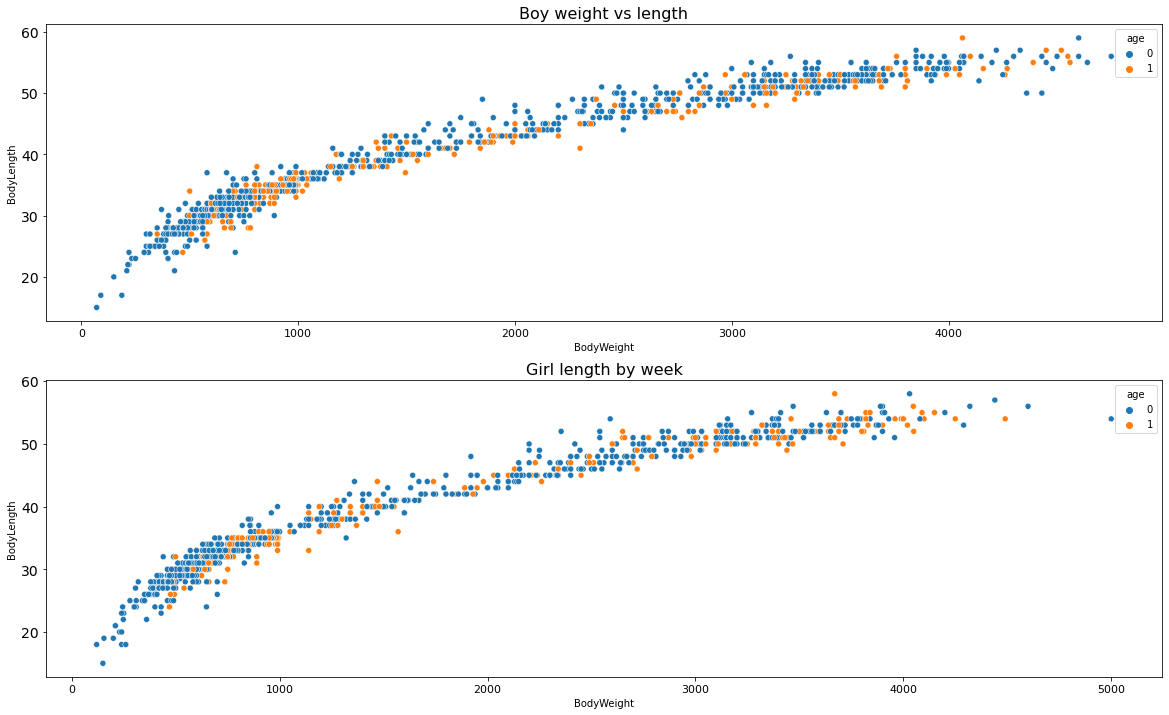

In [140]:
matplotlib.rcParams['figure.figsize'] = [20, 12]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, axs = plt.subplots(2,1, sharex=False, sharey=False)
b = sns.scatterplot(
    data=source_raw[source_raw.gender == 1],
    x='BodyWeight',
    y='BodyLength',
    hue='age',
    ax=axs[0]
)
b.set_title('Boy weight vs length', size=16)
g = sns.scatterplot(
    data=source_raw[source_raw.gender == 2],
    x='BodyWeight',
    y='BodyLength',
    hue='age',
    ax=axs[1],
)
g.set_title('Girl length by week', size=16)
plt.show()

### Feature correlation

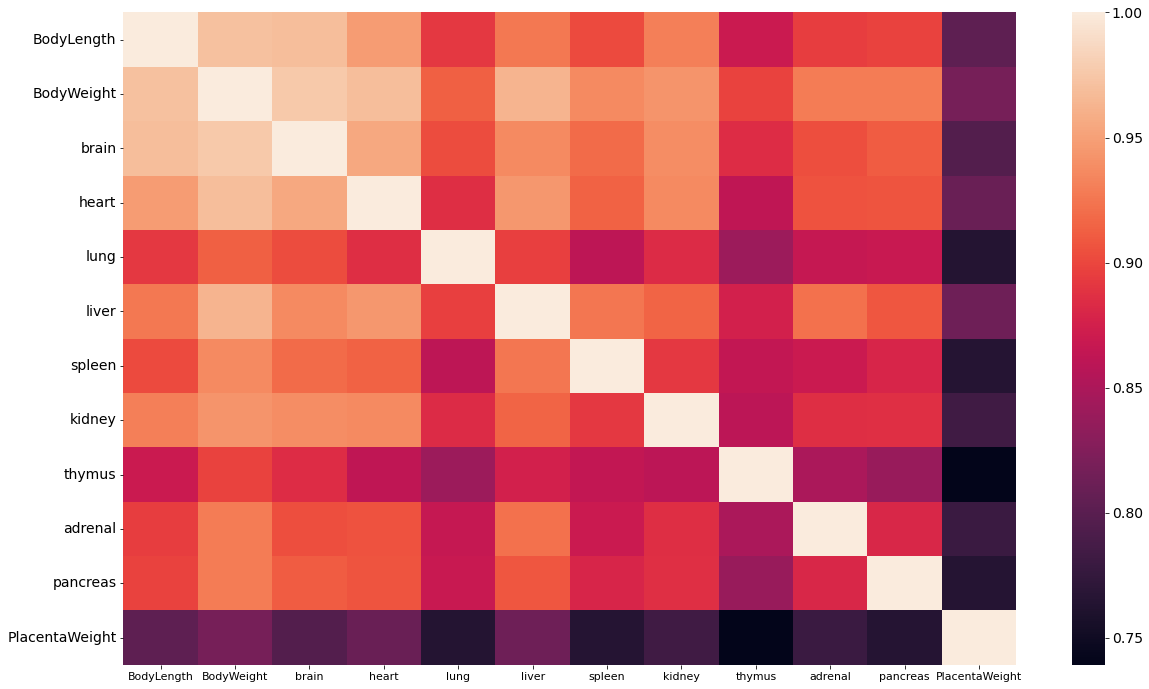

In [152]:
sns.heatmap(
    source_raw[[x for x in source_raw.columns if pd.api.types.is_numeric_dtype(source_raw[x])]].corr()
)
plt.show()

### Feature correlation including categorical features

In [260]:
def conditional_entropy(x: Iterable, y: Iterable) -> float:
    """
    https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 
    with minor improvements
    """
    y_counter: Dict[int, int] = Counter(y)
    xy_counter: Dict[int, int] = Counter(list(zip(x,y)))
    total_occurrences: int = sum(y_counter.values())
    entropy: int = 0
    for xy in xy_counter.keys():
        p_xy: float = xy_counter[xy] / total_occurrences
        p_y: float = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * log(p_y / p_xy)
    return entropy

def theil_u(x: Iterable, y: Iterable) -> float:
    """
    Taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 
    with minor improvements
    """
    s_xy: float = conditional_entropy(x,y)
    x_counter: Dict[int, int] = Counter(x)
    total_occurrences: int = sum(x_counter.values())
    p_x: Iterable = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x: float  = entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [262]:
def correlation_ratio(categories: Iterable, measurements: Iterable) -> float:
    """
    Taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 
    and https://www.kaggle.com/code/akshay22071995/alone-in-the-woods-using-theil-s-u-for-survival 
    with minor improvements
    """
    fcat, _ = pd.factorize(categories)
    cat_num: int = np.max(fcat) + 1
    y_avg_array: np.ndarray = np.zeros(cat_num)
    n_array: np.ndarray = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures: Iterable = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.nanmean(cat_measures)
    y_total_avg: numeric = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator: numeric  = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator: numeric = np.sum(np.power(np.subtract(measurements, y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta

In [263]:
def fullCorrmat(df: pd.core.frame.DataFrame) -> np.ndarray:
    nfact: int = df.shape[1]
    out_matrix: np.ndarray = np.empty((nfact, nfact), dtype=float)
    for i in range(nfact):
        i_col: Any = df.columns[i]
        for j in range(nfact):
            j_col: Any = df.columns[j]
            i_num: bool = pd.api.types.is_numeric_dtype(df[i_col])
            j_num: bool = pd.api.types.is_numeric_dtype(df[j_col])
            i_cat: bool = pd.api.types.is_categorical_dtype(df[i_col])
            j_cat: bool = pd.api.types.is_categorical_dtype(df[j_col])
            if i_num and j_num:
                out_matrix[i][j] = df[i_col].corr(df[j_col])
            elif i_cat and j_cat:
                out_matrix[i][j] = theil_u(df[i_col], df[j_col])
            elif (i_cat and j_num) or (i_num and j_cat):
                out_matrix[i][j] = correlation_ratio(df[i_col], df[j_col]) \
                    if i_cat else \
                    correlation_ratio(df[j_col], df[i_col])
            else:
                raise ValueError('Prohibited column types were provided!')
            if out_matrix[i][j] == np.nan:
                out_matrix[i][j] = 0
    out_matrix: pd.core.frame.DataFrame = pd.DataFrame(
        out_matrix,
        columns=df.columns,
        index=df.columns
    )
    return out_matrix

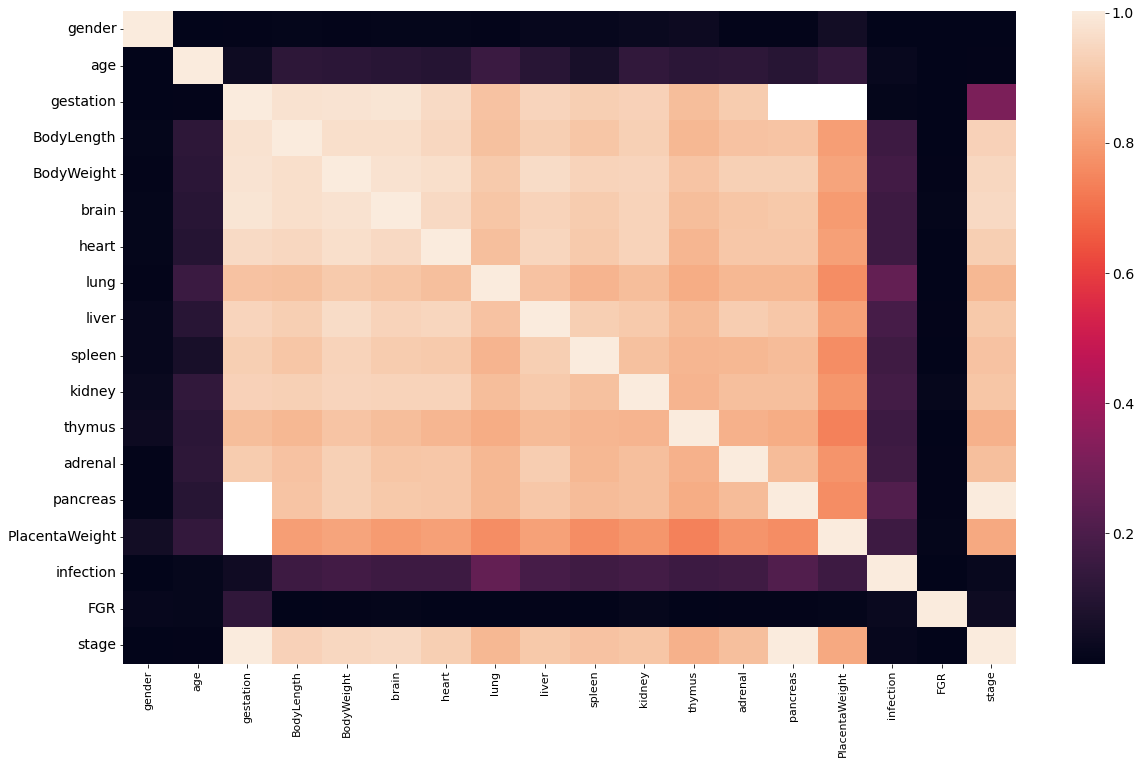

In [264]:
sns.heatmap(fullCorrmat(source_raw))
plt.show()

### Count distribution per week

In [158]:
sorted(source_raw['gestation'].unique())

[15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42]

In [160]:
week2count = Counter(sorted(source_raw['gestation']))

In [165]:
week2count

Counter({15: 1,
         16: 5,
         17: 1,
         18: 8,
         19: 11,
         20: 26,
         21: 89,
         22: 208,
         23: 352,
         24: 373,
         25: 370,
         26: 273,
         27: 262,
         28: 139,
         29: 90,
         30: 89,
         31: 64,
         32: 40,
         33: 42,
         34: 62,
         35: 51,
         36: 62,
         37: 76,
         38: 210,
         39: 184,
         40: 113,
         41: 54,
         42: 14})

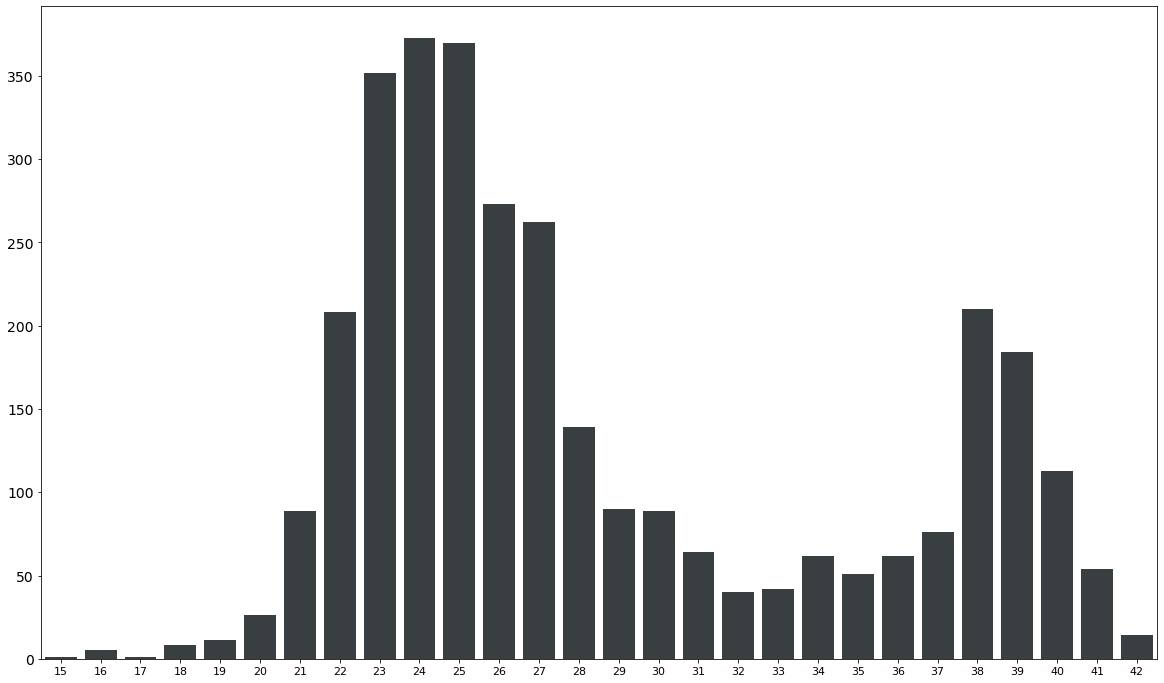

In [267]:
sns.barplot(
    x=list(week2count.keys()),
    y=list(week2count.values()),
    color='#383e42'
)
plt.show()

# Switching to filtered data

## Uploading the filtered dataset and the outlier data independently

In [268]:
with open(os.path.join('data', 'raw', 'no_na_no_outliers.csv'), 'r') as h:
    source_filt: pd.core.frame.DataFrame = pd.read_csv(
        h,
        header=0,
        index_col=None,
        sep=','
    )

In [269]:
with open(os.path.join('data', 'raw', 'outleirs_to_na.csv'), 'r') as h:
    na_outliers: pd.core.frame.DataFrame = pd.read_csv(
        h,
        header=0,
        index_col=None,
        sep=','
    )

In [273]:
for col in ['age', 'gender', 'gestation']:
    source_filt[col] = pd.Categorical(source_filt[col])

In [280]:
for col in ['age', 'gender', 'gestation']:
    na_outliers[col] = pd.Categorical(na_outliers[col])

In [321]:
source_filt['WLR'] = source_filt['BodyWeight'] / source_filt['BodyLength']

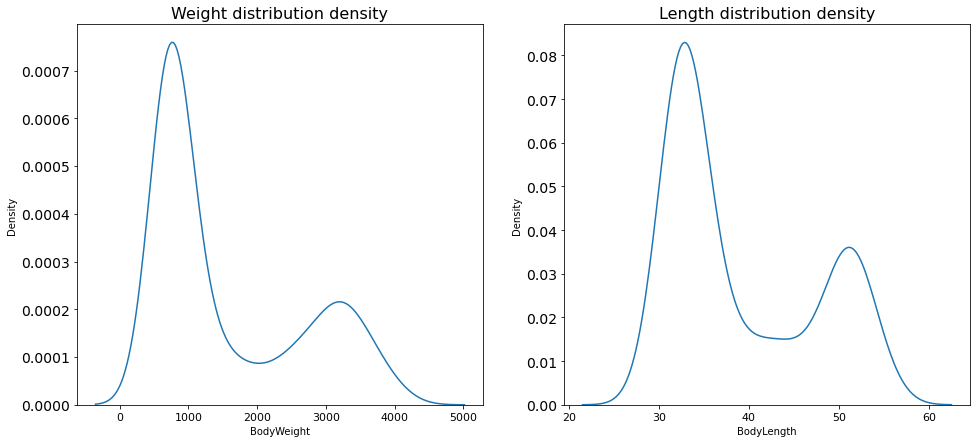

In [283]:
matplotlib.rcParams['figure.figsize'] = [16, 7]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False)
f1 = sns.kdeplot(
    data=source_filt,
    x='BodyWeight',
    ax=ax1
)
f1.set_title('Weight distribution density', size=16)
f2 = sns.kdeplot(
    data=source_filt,
    x='BodyLength',
    ax=ax2
)
f2.set_title('Length distribution density', size=16)
plt.show()

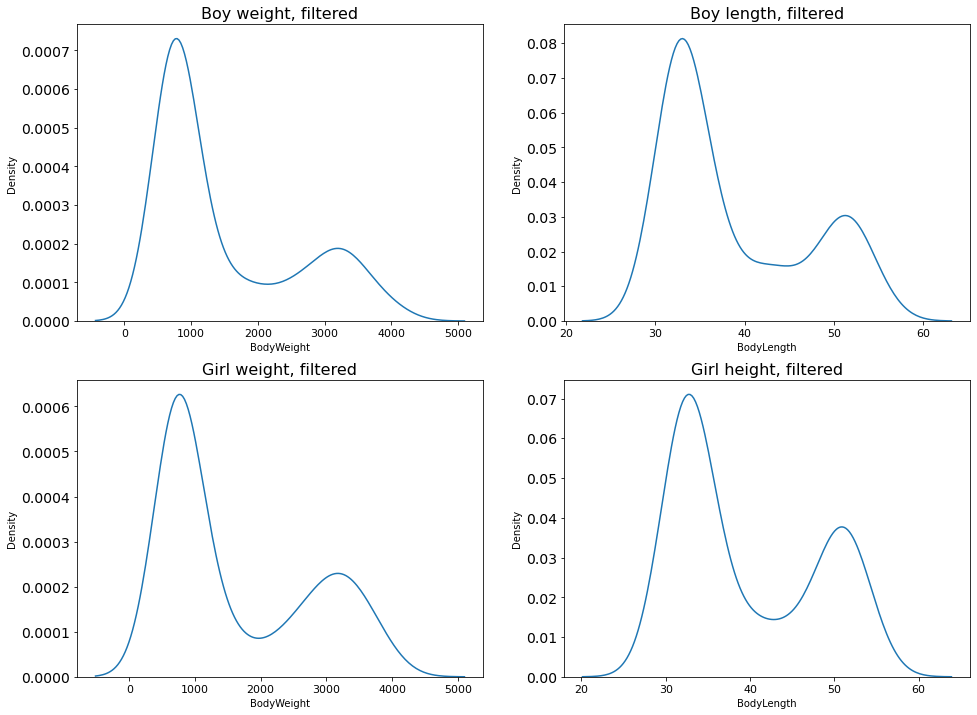

In [285]:
matplotlib.rcParams['figure.figsize'] = [16, 12]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, axs = plt.subplots(2,2, sharex=False, sharey=False)
bw = sns.kdeplot(
    data=source_filt[source_filt.gender == 1],
    x='BodyWeight',
    ax=axs[0][0]
)
bw.set_title('Boy weight, filtered', size=16)
bl = sns.kdeplot(
    data=source_filt[source_filt.gender == 1],
    x='BodyLength',
    ax=axs[0][1],
)
bl.set_title('Boy length, filtered', size=16)
gw = sns.kdeplot(
    data=source_filt[source_filt.gender == 2],
    x='BodyWeight',
    ax=axs[1][0]
)
gw.set_title('Girl weight, filtered', size=16)
gl = sns.kdeplot(
    data=source_filt[source_filt.gender == 2],
    x='BodyLength',
    ax=axs[1][1],
)
gl.set_title('Girl height, filtered', size=16)
plt.show()

In [293]:
for column in source_filt.columns:
    if pd.api.types.is_numeric_dtype(source_filt[column]):
        ks_stat, ks_pval = kstest(source_filt[column], 'norm')
        shap_stat, shap_pval = shapiro(source_filt[column])
        print(f'For column {column}, Kolmogorov-Smirnov stat is {ks_stat} (p-value is {ks_pval}), Shapiro-Wilk stat is {shap_stat} (p-value is {shap_pval})')

For column BodyLength, Kolmogorov-Smirnov stat is 1.0 (p-value is 0.0), Shapiro-Wilk stat is 0.8410872220993042 (p-value is 3.4793091558901714e-27)
For column BodyWeight, Kolmogorov-Smirnov stat is 1.0 (p-value is 0.0), Shapiro-Wilk stat is 0.7850107550621033 (p-value is 8.717635376884603e-31)
For column brain, Kolmogorov-Smirnov stat is 1.0 (p-value is 0.0), Shapiro-Wilk stat is 0.8074386715888977 (p-value is 1.9076706238816758e-29)
For column heart, Kolmogorov-Smirnov stat is 0.9986501019683699 (p-value is 0.0), Shapiro-Wilk stat is 0.8111153841018677 (p-value is 3.249145228429901e-29)
For column lung, Kolmogorov-Smirnov stat is 1.0 (p-value is 0.0), Shapiro-Wilk stat is 0.838173508644104 (p-value is 2.146277515254524e-27)
For column liver, Kolmogorov-Smirnov stat is 1.0 (p-value is 0.0), Shapiro-Wilk stat is 0.7867130041122437 (p-value is 1.0918122245409218e-30)
For column spleen, Kolmogorov-Smirnov stat is 0.7874294700736777 (p-value is 0.0), Shapiro-Wilk stat is 0.7878388166427612

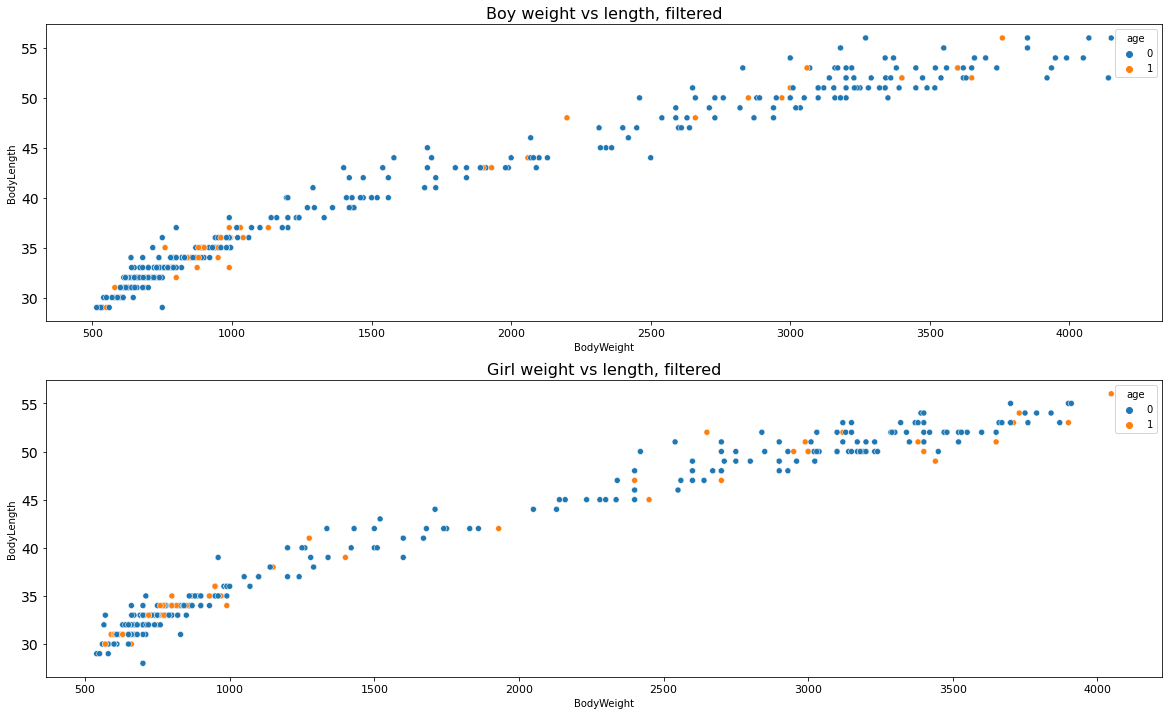

In [295]:
matplotlib.rcParams['figure.figsize'] = [20, 12]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, axs = plt.subplots(2,1, sharex=False, sharey=False)
b = sns.scatterplot(
    data=source_filt[source_filt.gender == 1],
    x='BodyWeight',
    y='BodyLength',
    hue='age',
    ax=axs[0]
)
b.set_title('Boy weight vs length, filtered', size=16)
g = sns.scatterplot(
    data=source_filt[source_filt.gender == 2],
    x='BodyWeight',
    y='BodyLength',
    hue='age',
    ax=axs[1],
)
g.set_title('Girl weight vs length, filtered', size=16)
plt.show()

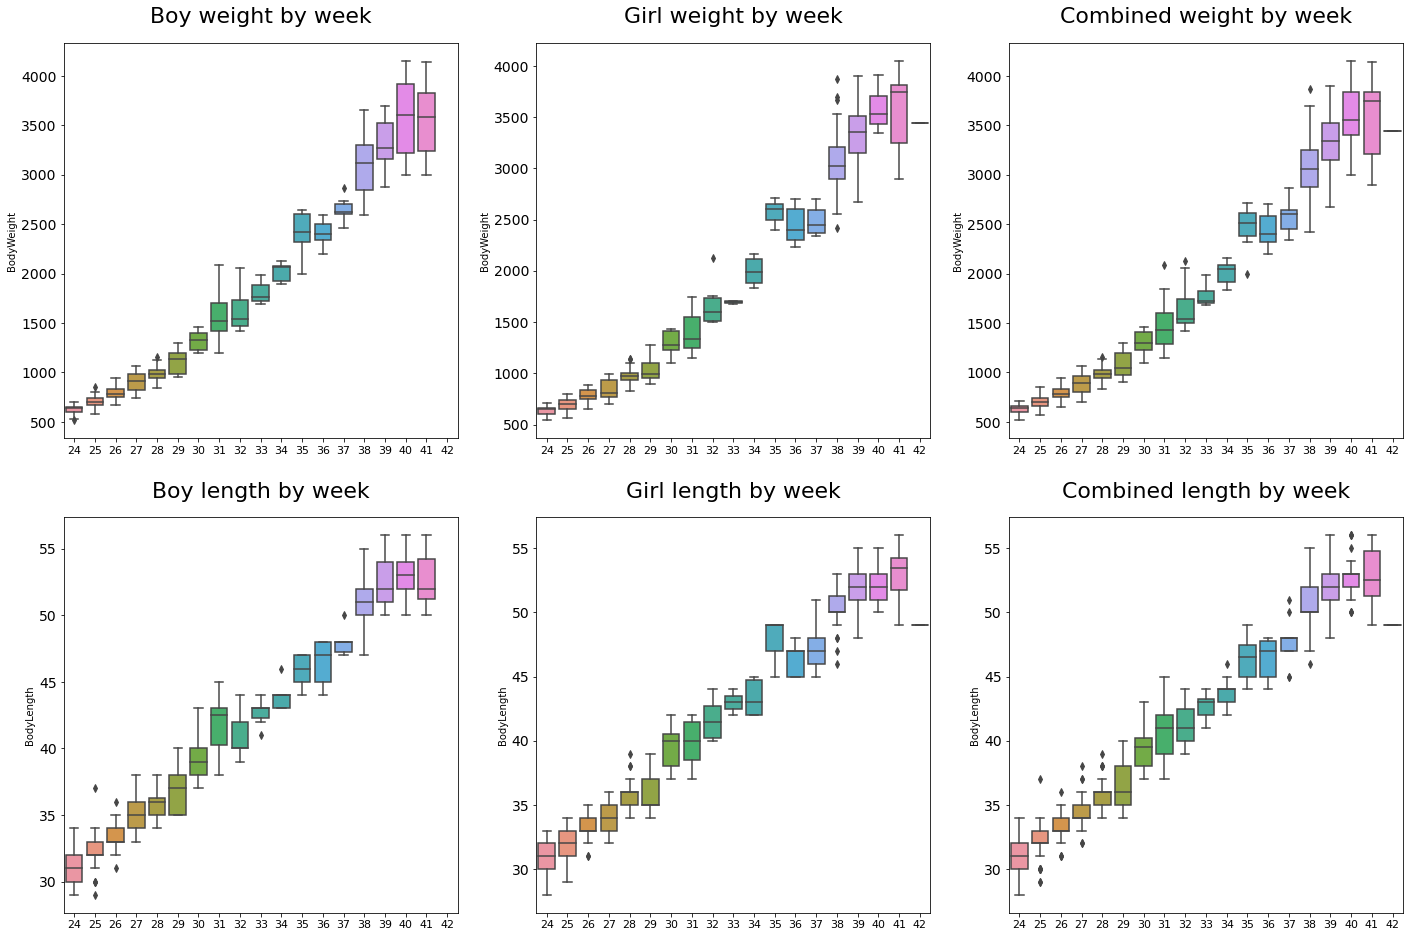

In [1122]:
matplotlib.rcParams['figure.figsize'] = [24, 16]
matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=14)
fig, axs = plt.subplots(2,3, sharex=False, sharey=False)
bw = sns.boxplot(
    data=source_filt[source_filt.gender == 1],
    x='gestation',
    y='BodyWeight',
    ax=axs[0][0]
)
bw.set_title('Boy weight by week', size=22, pad=20)
bw.set_xlabel('')
gw = sns.boxplot(
    data=source_filt[source_filt.gender == 2],
    x='gestation',
    y='BodyWeight',
    ax=axs[0][1]
)
gw.set_title('Girl weight by week', size=22, pad=20)
gw.set_xlabel('')
cw = sns.boxplot(
    data=source_filt,
    x='gestation',
    y='BodyWeight',
    ax=axs[0][2]
)
cw.set_title('Combined weight by week', size=22, pad=20)
cw.set_xlabel('')
bl = sns.boxplot(
    data=source_filt[source_filt.gender == 1],
    x='gestation',
    y='BodyLength',
    ax=axs[1][0],
)
bl.set_title('Boy length by week', size=22, pad=20)
bl.set_xlabel('')
gl = sns.boxplot(
    data=source_filt[source_filt.gender == 2],
    x='gestation',
    y='BodyLength',
    ax=axs[1][1],
)
gl.set_xlabel('')
gl.set_title('Girl length by week', size=22, pad=20)
cl = sns.boxplot(
    data=source_filt,
    x='gestation',
    y='BodyLength',
    ax=axs[1][2],
)
cl.set_title('Combined length by week', size=22, pad=20)
cl.set_xlabel('')
plt.savefig(
    os.path.join('source_figs', 'WL_byGender_byWeek.png'),
    
)
plt.show()

In [298]:
Counter(source_filt[source_filt['gender'] == 1]['gestation'])

Counter({25: 77,
         26: 55,
         40: 25,
         38: 44,
         27: 52,
         24: 57,
         28: 20,
         31: 10,
         36: 9,
         32: 13,
         29: 13,
         35: 5,
         39: 21,
         30: 9,
         41: 6,
         34: 9,
         33: 6,
         37: 6})

In [300]:
source_filt[(source_filt['gender'] == 1) & (source_filt['gestation'] == 25)]

,gender,age,gestation,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,kidney,thymus,adrenal,pancreas,PlacentaWeight
1,1,1,25,33,748,100.0,4.8,20.0,34.8,1.30,6.8,2.10,2.1,1.2,150.0
4,1,0,25,33,720,83.0,3.7,19.1,23.1,0.70,5.7,1.00,2.1,0.4,90.0
6,1,0,25,33,760,110.0,5.6,18.1,36.0,1.70,8.0,2.00,2.3,0.9,170.0
17,1,0,25,31,600,87.0,4.3,15.6,27.1,1.10,6.3,1.20,1.7,0.9,130.0
35,1,0,25,30,580,93.0,4.5,13.4,26.6,1.20,6.0,1.40,1.5,0.8,170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,1,0,25,33,730,100.0,4.3,22.4,38.1,1.30,7.2,0.70,2.9,0.9,142.0
767,1,0,25,32,700,100.0,4.7,13.2,26.4,1.20,6.4,1.70,1.5,0.7,160.0
768,1,0,25,34,738,106.0,6.5,19.1,33.6,1.80,5.1,1.70,2.3,0.8,178.0
774,1,0,25,34,680,102.0,5.3,14.7,28.5,1.42,8.4,2.42,2.3,0.5,222.0


In [303]:
week2count_filt: Dict[int, int] = Counter(source_filt['gestation'])

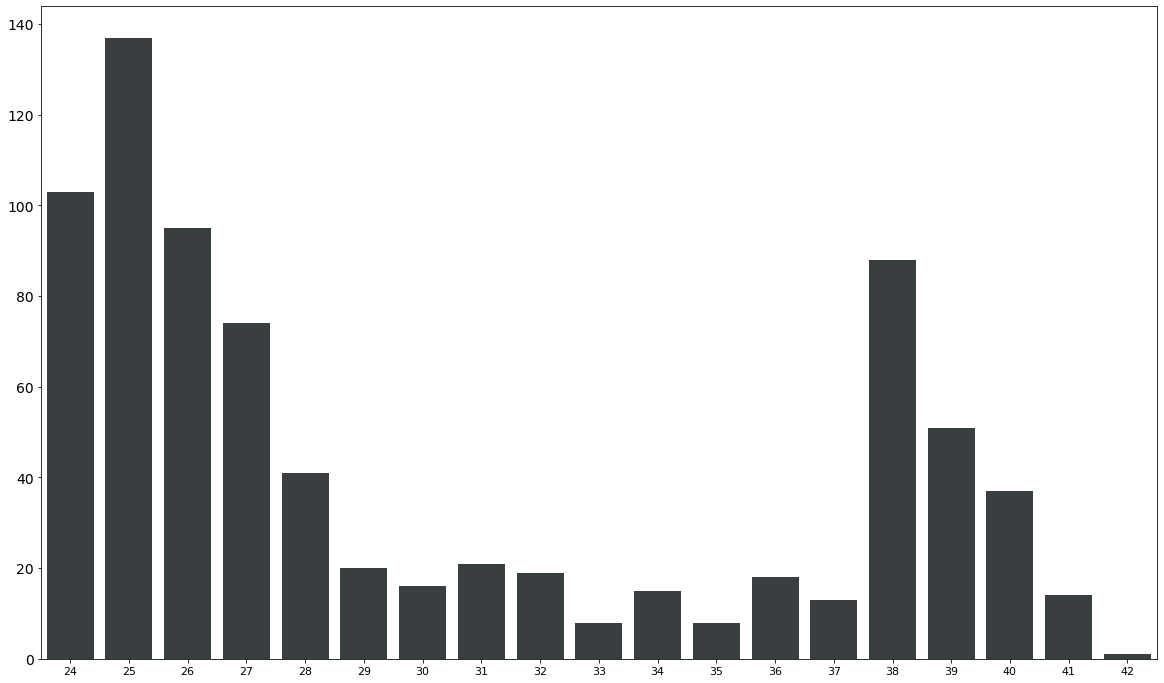

In [304]:
sns.barplot(
    x=list(week2count_filt.keys()),
    y=list(week2count_filt.values()),
    color='#383e42'
)
plt.show()

In [353]:
print('Body weight stats:')
print('\t'.join(['Week', 'Shapiro p-val, boys', 'Shapiro p-val, girls', 'KS p-val, b2g', 't-test p-val, b2g']))
for gest_week in sorted(source_filt['gestation'].unique()):
    boy_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 1)]['BodyWeight']
    girl_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 2)]['BodyWeight']
    if boy_vals.shape[0] >= 10 and girl_vals.shape[0] >= 10:
        boy_norm: float = shapiro(boy_vals)[1]
        girl_norm: float = shapiro(girl_vals)[1]
        b2g_ks: float = ks_2samp(boy_vals, girl_vals)[1]
        b2g_t: float = ttest_ind(boy_vals, girl_vals)[1]
        print('\t'.join(map(str, [gest_week, boy_norm, girl_norm, b2g_ks, b2g_t])))

Body weight stats:
Week	Shapiro p-val, boys	Shapiro p-val, girls	KS p-val, b2g	t-test p-val, b2g
24	0.029016949236392975	0.07878948748111725	0.3626120545446845	0.3181206968709826
25	0.358578085899353	0.01647390052676201	0.837496140378081	0.1802794512670159
26	0.2288329154253006	0.27805715799331665	0.9444848331598177	0.8085194113227692
27	0.011022032238543034	0.06297945231199265	0.08354686998691896	0.008726063278859041
28	0.6371365189552307	0.4447955787181854	0.967235582798769	0.692804637721468
31	0.8583127856254578	0.2666296660900116	0.19552841379466745	0.08464466630268222
38	0.27308622002601624	0.5640808939933777	0.6393820126874088	0.6306196522262928
39	0.47431862354278564	0.8944777846336365	0.9424503100158484	0.7386010265524896
40	0.1983901858329773	0.40965166687965393	0.278941410590956	0.9699871460350951


In [352]:
print('Body length stats:')
print('\t'.join(['Week', 'Shapiro p-val, boys', 'Shapiro p-val, girls', 'KS p-val, b2g', 't-test p-val, b2g']))
for gest_week in sorted(source_filt['gestation'].unique()):
    boy_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 1)]['BodyLength']
    girl_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 2)]['BodyLength']
    if boy_vals.shape[0] >= 10 and girl_vals.shape[0] >= 10:
        boy_norm: float = shapiro(boy_vals)[1]
        girl_norm: float = shapiro(girl_vals)[1]
        b2g_ks: float = ks_2samp(boy_vals, girl_vals)[1]
        b2g_t: float = ttest_ind(boy_vals, girl_vals)[1]
        print('\t'.join(map(str, [gest_week, boy_norm, girl_norm, b2g_ks, b2g_t])))

Body length stats:
Week	Shapiro p-val, boys	Shapiro p-val, girls	KS p-val, b2g	t-test p-val, b2g
24	0.0006210980354808271	0.0005210013478063047	0.9823325684847116	0.3880405318761687
25	3.175213578288094e-06	0.00016620299720671028	0.9245619153428271	0.28863110943685416
26	0.0011572481598705053	0.0008450208115391433	0.9976993565737106	0.8406270935445345
27	0.0013660442782565951	0.09226328879594803	0.5090770392189399	0.01956256836004647
28	0.11734054982662201	0.06525149941444397	0.9996609573353853	0.6939405712106479
31	0.6951188445091248	0.2954185903072357	0.11538178024246137	0.03651876096073949
38	0.15619130432605743	0.012576140463352203	0.9944453655343248	0.4217496015880182
39	0.10841021686792374	0.10645203292369843	0.8917212483605854	0.33091835528718505
40	0.039335351437330246	0.6866130828857422	0.5343382552700098	0.12931860955253177


In [ ]:
print('Brain stats:')
print('\t'.join(['Week', 'Shapiro p-val, boys', 'Shapiro p-val, girls', 'KS p-val, b2g', 't-test p-val, b2g']))
for gest_week in sorted(source_filt['gestation'].unique()):
    boy_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 1)]['BodyLength']
    girl_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 2)]['BodyLength']
    if boy_vals.shape[0] >= 10 and girl_vals.shape[0] >= 10:
        boy_norm: float = shapiro(boy_vals)[1]
        girl_norm: float = shapiro(girl_vals)[1]
        b2g_ks: float = ks_2samp(boy_vals, girl_vals)[1]
        b2g_t: float = ttest_ind(boy_vals, girl_vals)[1]
        print('\t'.join(map(str, [gest_week, boy_norm, girl_norm, b2g_ks, b2g_t])))

In [312]:
kstest(source_filt[(source_filt['gender'] == 1) & (source_filt['gestation'] == 25)]['BodyWeight'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [313]:
shapiro(source_filt[(source_filt['gender'] == 1) & (source_filt['gestation'] == 25)]['BodyWeight'])

ShapiroResult(statistic=0.9822587966918945, pvalue=0.358578085899353)

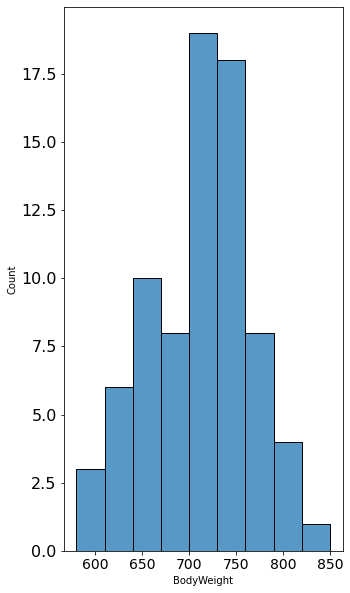

In [1099]:
sns.histplot(source_filt[(source_filt['gender'] == 1) & (source_filt['gestation'] == 25)]['BodyWeight'])
plt.savefig(os.path.join('data', 'raw', 'boy_week25_weight.png'))
plt.show()

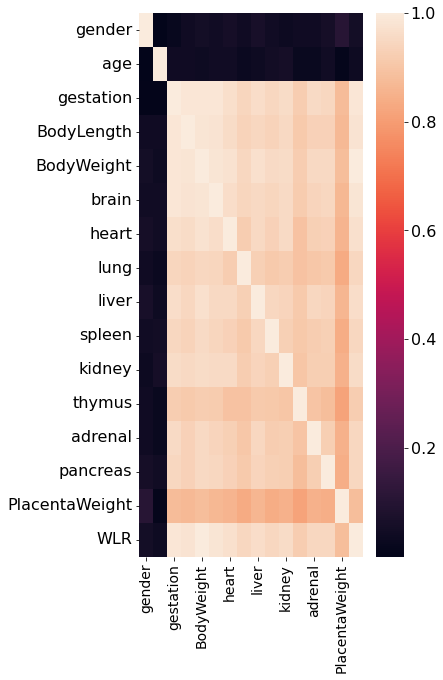

In [1100]:
sns.heatmap(fullCorrmat(source_filt))
plt.savefig(
    os.path.join('source_figs', 'heatmap_corr_filt.png'),
)
plt.show()

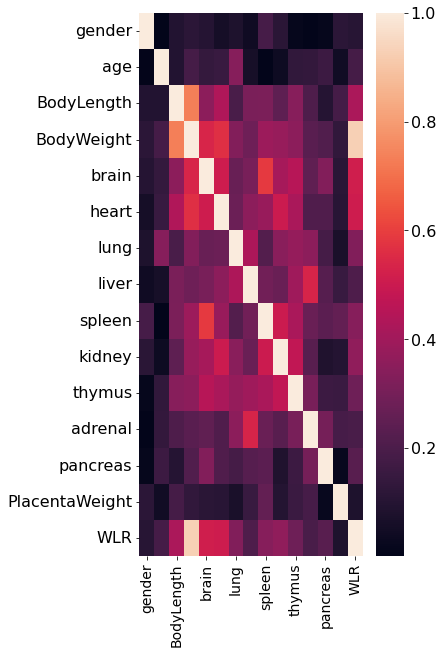

In [1101]:
sns.heatmap(fullCorrmat(source_filt[source_filt['gestation'] == 25].drop('gestation', axis=1).reset_index().drop('index', axis=1)))
plt.savefig(
    os.path.join('source_figs', 'heatmap_corr_filt_week25.png'),
)
plt.show()

In [351]:
ttest_ind(
    source_filt[(source_filt['gender'] == 1) & (source_filt['gestation'] == 25)]['BodyWeight'],
    source_filt[(source_filt['gender'] == 2) & (source_filt['gestation'] == 25)]['BodyWeight']
)

Ttest_indResult(statistic=1.346867861096724, pvalue=0.1802794512670159)

## Imputing missing data for the full dataset

In [366]:
missing_values: pd.core.frame.DataFrame = pd.DataFrame(na_outliers.apply(lambda x: x.isna().sum(), axis=0))

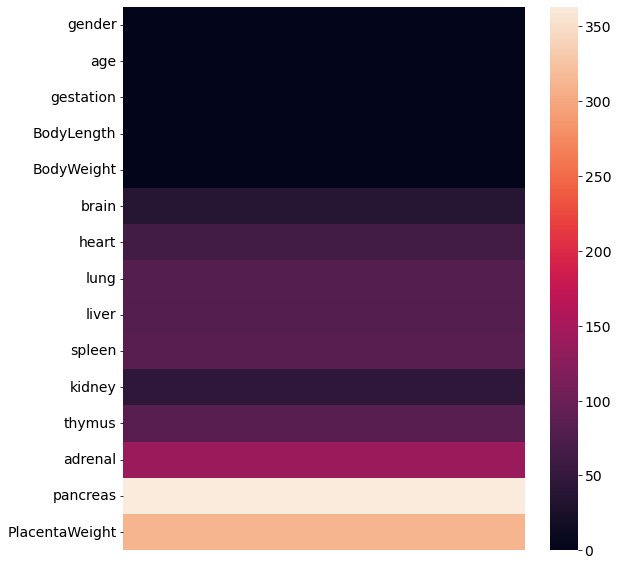

In [1128]:
matplotlib.rcParams['figure.figsize'] = [9, 10]
msn_hm = sns.heatmap(missing_values)
plt.xticks([])
plt.savefig(
    os.path.join('source_figs', 'missing_data_hm.png')
)
plt.show()

In [388]:
columns_to_impute: List[str] = [x for x in missing_values.index if missing_values.loc[x,0] != 0 ]

### Trying MICE for missing data imputing

In [395]:
os.makedirs('meta')

In [396]:
os.makedirs(os.path.join('meta', 'datawig_models'))

In [498]:
imputed: pd.core.frame.DataFrame = pd.DataFrame(
    mice(na_outliers.values)
)

In [499]:
imputed.columns = na_outliers.columns

In [500]:
for col in ['age', 'gender']:
    imputed[col] = pd.Categorical(imputed[col])

In [503]:
gestation_series = pd.CategoricalDtype(
    categories=sorted(source_raw['gestation'].unique()),
    ordered=True
)

In [504]:
imputed['gestation'] = imputed['gestation'].astype(gestation_series)

In [505]:
imputed.describe()

,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,kidney,thymus,adrenal,pancreas,PlacentaWeight
count,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000
mean,38.929472,1530.060624,197.657534,9.717397,31.950232,66.880594,4.392314,13.856227,4.960264,4.209960,1.841202,244.420070
std,8.019457,1068.858907,119.350169,6.373417,18.882812,48.744069,4.174179,8.537445,4.371193,2.951847,1.358112,106.716418
min,27.000000,490.000000,64.250000,3.000000,10.100000,18.700000,0.440000,3.900000,0.500000,1.000000,0.200000,59.670000
25%,33.000000,719.000000,104.000000,4.900000,18.000000,32.425000,1.450624,7.400000,1.900000,2.100000,0.850000,170.000000
50%,35.000000,940.000000,135.000000,6.400000,22.600000,40.300000,2.100000,9.700000,2.800000,2.700000,1.182401,205.000000
75%,47.000000,2447.500000,311.500000,15.000000,45.675000,98.000000,7.100000,20.627329,7.548793,6.000000,2.900000,310.000000
max,57.000000,4300.000000,512.000000,31.300000,122.000000,250.000000,21.300000,43.700000,21.500000,14.000000,6.700000,625.000000


In [508]:
imputed.apply(lambda x: x.isna().sum() if pd.api.types.is_categorical_dtype(x) else (x == 0).sum(), axis=0)

gender            0
age               0
gestation         0
BodyLength        0
BodyWeight        0
brain             0
heart             0
lung              0
liver             0
spleen            0
kidney            0
thymus            0
adrenal           0
pancreas          0
PlacentaWeight    0
dtype: int64

In [515]:
for week in set(source_filt['gestation']).intersection(set(imputed['gestation'])):
    filt_sub: pd.core.series.Series = source_filt[source_filt['gestation'] == week]['BodyWeight']
    imp_sub: pd.core.series.Series = imputed[imputed['gestation'] == week]['BodyWeight']
    if filt_sub.shape[0] >= 10 and imp_sub.shape[0] >= 10:
        print('\t'.join(map(str, [week, shapiro(filt_sub)[1], shapiro(imp_sub)[1]])))

24	0.004688899498432875	2.0023879187647253e-05
25	0.012158338911831379	0.006928895600140095
26	0.35616785287857056	0.006731287110596895
27	0.0032945943530648947	1.8219051298729028e-06
28	0.1684207171201706	0.007544157560914755
29	0.018604131415486336	0.010708297602832317
30	0.21446798741817474	0.1277814656496048
31	0.20801864564418793	0.17073173820972443
32	0.005121293943375349	0.016357675194740295
34	0.20174387097358704	0.47545504570007324
36	0.43366748094558716	0.32544955611228943
37	0.7823846340179443	0.0027970264200121164
38	0.8239303231239319	0.3419353663921356
39	0.9249470233917236	0.31793156266212463
40	0.5828352570533752	0.23109155893325806
41	0.25331154465675354	0.03613928705453873


In [516]:
for week in set(source_filt['gestation']).intersection(set(imputed['gestation'])):
    filt_sub: pd.core.series.Series = source_filt[source_filt['gestation'] == week]['BodyLength']
    imp_sub: pd.core.series.Series = imputed[imputed['gestation'] == week]['BodyLength']
    if filt_sub.shape[0] >= 10 and imp_sub.shape[0] >= 10:
        print('\t'.join(map(str, [week, shapiro(filt_sub)[1], shapiro(imp_sub)[1]])))

24	7.3310484367539175e-06	7.231722859435408e-11
25	2.2308345393184936e-08	4.073899551038096e-10
26	1.5695412002969533e-05	1.478039823865629e-08
27	0.0008343503577634692	4.675028719702823e-07
28	0.007078296504914761	0.0008708612876944244
29	0.006324355024844408	0.0030579823069274426
30	0.26128119230270386	0.03785277530550957
31	0.5683104991912842	0.12108074873685837
32	0.03775330260396004	0.004965127911418676
34	0.21782086789608002	0.008949358016252518
36	0.009720097295939922	0.023206759244203568
37	0.13078558444976807	0.011207322590053082
38	0.0034003511536866426	0.0005648932419717312
39	0.06312240660190582	0.0034249271266162395
40	0.027565423399209976	0.028006594628095627
41	0.5950241088867188	0.08271479606628418


In [519]:
imputed[imputed['BodyWeight'] == source_filt['BodyWeight'].max()]

,gender,age,gestation,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,kidney,thymus,adrenal,pancreas,PlacentaWeight
1352,1.0,0.0,40,56.0,4150.0,404.0,20.5,66.3,175.0,13.8,27.5,14.0,9.0,2.4,530.0


In [520]:
source_filt[source_filt['BodyWeight'] == source_filt['BodyWeight'].max()]

,gender,age,gestation,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,kidney,thymus,adrenal,pancreas,PlacentaWeight,WLR
614,1,0,40,56,4150,404.0,20.5,66.3,175.0,13.8,27.5,14.0,9.0,2.4,530.0,74.107143


In [525]:
for week in set(source_filt['gestation']).intersection(set(imputed['gestation'])):
    filt_sub: pd.core.series.Series = source_filt[source_filt['gestation'] == week]['BodyWeight']
    imp_sub: pd.core.series.Series = imputed[imputed['gestation'] == week]['BodyWeight']
    if filt_sub.shape[0] >= 10 and imp_sub.shape[0] >= 10:
        print('\t'.join(map(str, [week, ks_2samp(filt_sub, imp_sub)[1]])))

24	0.7228682627235439
25	0.8882765552226071
26	0.293983108480257
27	0.9998012323505902
28	0.9943303035461288
29	0.46732333640346535
30	0.912434652157211
31	0.916343577576379
32	0.999448065618151
34	0.13521115948911877
36	0.9989414927004742
37	0.856230031866629
38	0.9109095775512049
39	0.7893953870881608
40	0.9330500504164979
41	0.9948931964897416


In [526]:
ks_2samp(source_filt['gestation'], imputed['gestation'])

KstestResult(statistic=0.036302582650518486, pvalue=0.4723739467469409)

### Trying different initial MICE strategies

In [673]:
diff_imps: Dict[str, pd.core.frame.DataFrame] = dict()
train_sample: pd.core.frame.DataFrame = na_outliers.sample(frac=0.2)
for strategy in ['mean', 'median', 'most_frequent', 'constant']:
    # imputed: pd.core.frame.DataFrame = pd.DataFrame(
    #     mice(na_outliers.values, initial_strategy=strategy)
    # )
    iterimp: IterativeImputer = IterativeImputer(
        missing_values=np.nan, 
        random_state=42, 
        initial_strategy=strategy, 
        max_iter=20
    )
    iterimp.fit(train_sample.values)
    imputed: pd.core.frame.DataFrame = pd.DataFrame(iterimp.transform(na_outliers.values))
    imputed.columns = na_outliers.columns
    for col in ['age', 'gender']:
        imputed[col] = pd.Categorical(imputed[col])
    imputed['gestation'] = imputed['gestation'].astype(gestation_series)
    print(f'INITIAL STRATEGY: {strategy}')
    for week in set(source_filt['gestation']).intersection(set(imputed['gestation'])):
        filt_sub: pd.core.series.Series = source_filt[source_filt['gestation'] == week]['BodyWeight']
        imp_sub: pd.core.series.Series = imputed[imputed['gestation'] == week]['BodyWeight']
        if filt_sub.shape[0] >= 10 and imp_sub.shape[0] >= 10:
            print('\t'.join(map(str, [week, 'weight', shapiro(filt_sub)[1], shapiro(imp_sub)[1]])))
        filt_sub: pd.core.series.Series = source_filt[source_filt['gestation'] == week]['BodyLength']
        imp_sub: pd.core.series.Series = imputed[imputed['gestation'] == week]['BodyLength']
        if filt_sub.shape[0] >= 10 and imp_sub.shape[0] >= 10:
            print('\t'.join(map(str, [week, 'length', shapiro(filt_sub)[1], shapiro(imp_sub)[1]])))
    diff_imps[strategy] = imputed

INITIAL STRATEGY: mean
24	weight	0.004688899498432875	2.0023879187647253e-05
24	length	7.3310484367539175e-06	7.231722859435408e-11
25	weight	0.012158338911831379	0.006928895600140095
25	length	2.2308345393184936e-08	4.073899551038096e-10
26	weight	0.35616785287857056	0.006731287110596895
26	length	1.5695412002969533e-05	1.478039823865629e-08
27	weight	0.0032945943530648947	1.8219051298729028e-06
27	length	0.0008343503577634692	4.675028719702823e-07
28	weight	0.1684207171201706	0.007544157560914755
28	length	0.007078296504914761	0.0008708612876944244
29	weight	0.018604131415486336	0.010708297602832317
29	length	0.006324355024844408	0.0030579823069274426
30	weight	0.21446798741817474	0.1277814656496048
30	length	0.26128119230270386	0.03785277530550957
31	weight	0.20801864564418793	0.17073173820972443
31	length	0.5683104991912842	0.12108074873685837
32	weight	0.005121293943375349	0.016357675194740295
32	length	0.03775330260396004	0.004965127911418676
34	weight	0.20174387097358704	0.47545

# Inferring category-wise organ sizes based on Bartosch's data

In [603]:
imputed_means: pd.core.frame.DataFrame = imputed.groupby('gestation').apply('mean').loc[24:,:].reset_index()
filtered_means: pd.core.frame.DataFrame = source_filt.groupby('gestation').apply('mean').loc[24:,:].reset_index()

In [550]:
with open(os.path.join('data', 'raw', 'Bartosch.csv'), 'r') as h:
    bartosch: pd.core.frame.DataFrame = pd.read_csv(h, header=0, index_col=None, sep=';', decimal=',')

In [620]:
bart_new_names: List[str] = [
    'gestation', 'BodyWeight', 'BodyLength',
    'brain', 'heart', 'liver',
    'lung', 'kidney', 'adrenal', 
    'spleen', 'thymus'
]

In [552]:
bartosch_processed: pd.core.frame.DataFrame = bartosch.loc[
    :, (~bartosch.columns.str.contains('Unnamed')) & ~(bartosch.columns.str.contains('SD'))
]

In [553]:
bartosch_processed.columns = bart_new_names

In [554]:
bartosch_processed['gestation'] = bartosch_processed['gestation'].astype(gestation_series)

In [555]:
for col in bart_new_names[1:]:
    bartosch_processed[col] = bartosch_processed[col].astype(np.float64)

In [556]:
bartosch_processed['BodyLength'] = bartosch_processed['BodyLength'] / 10

## Trying a naïve linear model

In [610]:
X: np.ndarray = bartosch_processed.loc[3:, ['gestation', 'BodyWeight', 'BodyLength']].to_numpy()
X_inp: np.ndarray = imputed_means[['gestation', 'BodyWeight', 'BodyLength']].to_numpy()
X_filt: np.ndarray = filtered_means[['gestation', 'BodyWeight', 'BodyLength']].to_numpy()

In [670]:
print('Comparison to imputed data')
for strategy in diff_imps:
    print(f'INITIAL STRATEGY: {strategy}')
    imp_m: pd.core.frame.DataFrame = diff_imps[strategy].groupby('gestation').apply('mean').loc[24:,:].reset_index()
    X_test: np.ndarray = imp_m[['gestation', 'BodyWeight', 'BodyLength']].to_numpy()
    for col in bartosch_processed.columns[3:]:
        y: np.ndarray = bartosch_processed.loc[3:, col].to_numpy()
        y_test: np.ndarray = imp_m[col].to_numpy()
        ln = LinearRegression().fit(X, y)
        print('\t'.join(map(str, [col, round(ln.score(X, y), 3), round(ln.score(X_test, y_test), 3)])))

Comparison to imputed data
INITIAL STRATEGY: mean
brain	1.0	0.817
heart	1.0	0.916
liver	1.0	0.2
lung	1.0	0.68
kidney	1.0	0.241
adrenal	1.0	0.835
spleen	1.0	0.833
thymus	1.0	0.885
INITIAL STRATEGY: median
brain	1.0	0.817
heart	1.0	0.916
liver	1.0	0.2
lung	1.0	0.68
kidney	1.0	0.241
adrenal	1.0	0.835
spleen	1.0	0.833
thymus	1.0	0.885
INITIAL STRATEGY: most_frequent
brain	1.0	0.817
heart	1.0	0.916
liver	1.0	0.2
lung	1.0	0.68
kidney	1.0	0.241
adrenal	1.0	0.835
spleen	1.0	0.833
thymus	1.0	0.885
INITIAL STRATEGY: constant
brain	1.0	0.817
heart	1.0	0.916
liver	1.0	0.2
lung	1.0	0.68
kidney	1.0	0.241
adrenal	1.0	0.835
spleen	1.0	0.833
thymus	1.0	0.885


In [672]:
print('Comparison to filtered data')
for col in bartosch_processed.columns[3:]:
    y: np.ndarray = bartosch_processed.loc[3:, col].to_numpy()
    y_test: np.ndarray = filtered_means[col].to_numpy()
    ln = LinearRegression().fit(X, y)
    print('\t'.join(map(str, [col, round(ln.score(X, y), 3), round(ln.score(X_filt, y_test), 3)])))

Comparison to filtered data
brain	1.0	0.792
heart	1.0	0.759
liver	1.0	-0.005
lung	1.0	0.56
kidney	1.0	0.012
adrenal	1.0	0.808
spleen	1.0	0.742
thymus	1.0	0.842


In [681]:
print('Comparison to imputed data, genderwise')
for col in ['kidney', 'liver', 'lung']:
    for gender in na_outliers.gender.unique():
        gen_data: pd.core.frame.DataFrame = diff_imps['mean'][diff_imps['mean']['gender'] == gender]
        imp_m: pd.core.frame.DataFrame = gen_data.groupby('gestation').apply('mean').loc[24:,:].reset_index()
        X_inp: np.ndarray = imp_m[['gestation', 'BodyWeight', 'BodyLength']].to_numpy()
        y: np.ndarray = bartosch_processed.loc[3:, col].to_numpy()
        y_test: np.ndarray = imp_m[col].to_numpy()
        ln = LinearRegression().fit(X, y)
        print('\t'.join(map(str, [col, gender, round(ln.score(X, y), 3), round(ln.score(X_inp, y_test), 3)])))

Comparison to imputed data, genderwise
kidney	2	1.0	0.157
kidney	1	1.0	0.265
liver	2	1.0	0.267
liver	1	1.0	0.123
lung	2	1.0	0.694
lung	1	1.0	0.667


In [694]:
print('Comparison to imputed data, weight as only numeric predictor')
X_w: np.ndarray = bartosch_processed.loc[3:,:][['gestation', 'BodyWeight']].to_numpy()
for col in bartosch_processed.columns[3:]:
    gen_data: pd.core.frame.DataFrame = diff_imps['mean']
    imp_m: pd.core.frame.DataFrame = gen_data.groupby('gestation').apply('mean').loc[24:,:].reset_index()
    X_inp: np.ndarray = gen_data[['gestation', 'BodyWeight']].to_numpy()
    y: np.ndarray = bartosch_processed.loc[3:, col].to_numpy()
    y_test: np.ndarray = gen_data[col].to_numpy()
    ln = LinearRegression().fit(X_w, y)
    print('\t'.join(map(str, [col, round(ln.score(X_w, y), 3), round(ln.score(X_inp, y_test), 3)])))

Comparison to imputed data, weight as only numeric predictor
brain	1.0	0.937
heart	1.0	0.919
liver	0.999	0.937
lung	1.0	0.88
kidney	0.999	0.895
adrenal	1.0	0.889
spleen	1.0	0.891
thymus	1.0	0.81


In [696]:
print('Comparison to imputed data, stage asd only predictor')
X_w: np.ndarray = bartosch_processed.loc[3:,:][['gestation']].to_numpy()
for col in bartosch_processed.columns[3:]:
    gen_data: pd.core.frame.DataFrame = diff_imps['mean']
    imp_m: pd.core.frame.DataFrame = gen_data.groupby('gestation').apply('mean').loc[24:,:].reset_index()
    X_inp: np.ndarray = gen_data[['gestation']].to_numpy()
    y: np.ndarray = bartosch_processed.loc[3:, col].to_numpy()
    y_test: np.ndarray = gen_data[col].to_numpy()
    ln = LinearRegression().fit(X_w, y)
    print('\t'.join(map(str, [col, round(ln.score(X_w, y), 3), round(ln.score(X_inp, y_test), 3)])))

Comparison to imputed data, stage asd only predictor
brain	0.975	0.898
heart	0.959	0.842
liver	0.965	0.795
lung	0.986	0.815
kidney	0.98	0.85
adrenal	0.974	0.763
spleen	0.927	0.753
thymus	0.929	0.722


In [698]:
bartosch_processed['WLR'] = bartosch_processed['BodyWeight'] / bartosch_processed['BodyLength'] 

In [701]:
print('Comparison to imputed data, WLR + stage')
X_w: np.ndarray = bartosch_processed.loc[3:,:][['gestation', 'WLR']].to_numpy()
for col in bartosch_processed.columns[3:]:
    gen_data: pd.core.frame.DataFrame = diff_imps['mean']
    gen_data['WLR'] = gen_data['BodyWeight'] / gen_data['BodyLength']
    imp_m: pd.core.frame.DataFrame = gen_data.groupby('gestation').apply('mean').loc[24:,:].reset_index()
    X_inp: np.ndarray = gen_data[['gestation', 'WLR']].to_numpy()
    y: np.ndarray = bartosch_processed.loc[3:, col].to_numpy()
    y_test: np.ndarray = gen_data[col].to_numpy()
    ln = LinearRegression().fit(X_w, y)
    print('\t'.join(map(str, [col, round(ln.score(X_w, y), 3), round(ln.score(X_inp, y_test), 3)])))

Comparison to imputed data, WLR + stage
brain	1.0	0.749
heart	1.0	0.789
liver	0.999	0.879
lung	1.0	0.861
kidney	0.999	0.776
adrenal	1.0	0.854
spleen	0.999	0.675
thymus	1.0	0.593
WLR	1.0	1.0


### Trying the normalized input data

In [742]:
print('Comparison to imputed data, WLR + stage')
X_w: np.ndarray = bartosch_processed.loc[3:,:][['gestation', 'BodyWeight', 'BodyLength']].se .to_numpy()
for col in bartosch_processed.columns[3:-1]:
    gen_data: pd.core.frame.DataFrame = diff_imps['mean']
    gen_data['WLR'] = gen_data['BodyWeight'] / gen_data['BodyLength']
    imp_m: pd.core.frame.DataFrame = gen_data.groupby('gestation').apply('mean').loc[24:,:].reset_index()
    X_inp: np.ndarray = gen_data[['gestation', 'WLR']].to_numpy()
    y: np.ndarray = bartosch_processed.loc[3:, col].to_numpy()
    y_test: np.ndarray = gen_data[col].to_numpy()
    ln = LinearRegression().fit(X_w, y)
    print('\t'.join(map(str, [col, round(ln.score(X_w, y), 3), round(ln.score(X_inp, y_test), 3)])))

Comparison to imputed data, normalized predictors
brain	1.0	0.661
heart	1.0	0.764
liver	1.0	-0.545
lung	1.0	0.379
kidney	1.0	-0.351
adrenal	1.0	0.707
spleen	1.0	0.635
thymus	1.0	0.629
WLR	1.0	0.976


In [744]:
bartosch_processed

,gestation,BodyWeight,BodyLength,brain,heart,liver,lung,kidney,adrenal,spleen,thymus,WLR
0,NaN,21.1,8.49,5.17,0.15,1.24,0.64,0.27,0.15,0.01,0.02,2.485277
1,NaN,25.2,10.74,5.80,0.22,1.28,0.99,0.27,0.24,0.02,0.03,2.346369
2,NaN,39.1,12.93,7.84,0.33,1.94,1.53,0.33,0.34,0.02,0.03,3.023975
3,15,62.5,15.07,11.24,0.48,3.16,2.25,0.51,0.46,0.03,0.13,4.147313
4,16,95.2,17.16,15.97,0.68,4.87,3.15,0.80,0.60,0.04,0.13,5.547786
5,17,137.0,19.20,21.98,0.93,7.04,4.21,1.20,0.75,0.07,0.16,7.135417
6,18,187.8,21.19,29.24,1.21,9.61,5.44,1.70,0.91,0.13,0.23,8.862671
7,19,247.5,23.12,37.69,1.55,12.53,6.82,2.30,1.09,0.23,0.34,10.705017
8,20,315.7,25.01,47.31,1.92,15.77,8.34,2.99,1.28,0.36,0.48,12.622951
9,21,392.3,26.84,58.05,2.35,19.30,10.01,3.76,1.49,0.53,0.66,14.616244


### Plotting weight and length gain through stages

In [705]:
from matplotlib.lines import Line2D

In [736]:
os.makedirs('impute_figs')

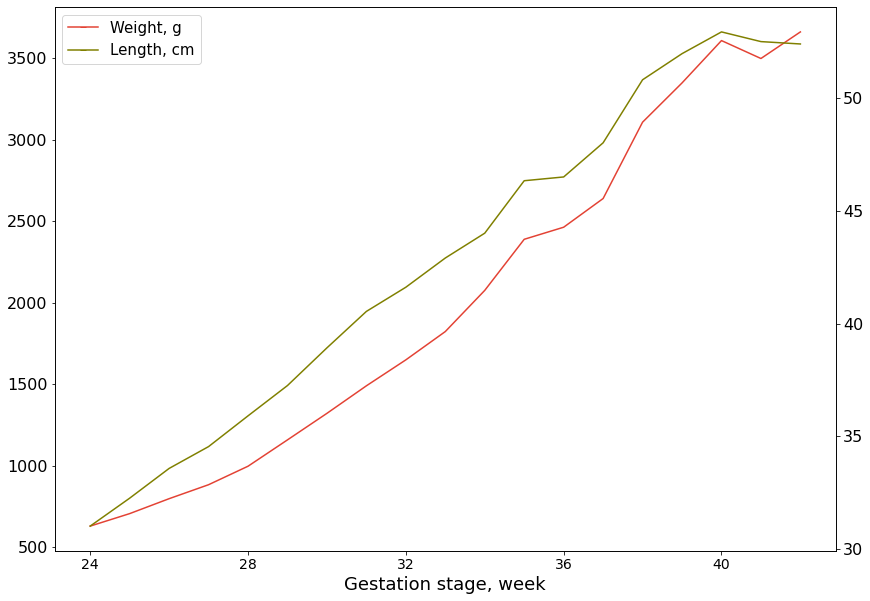

In [737]:
gen_data: pd.core.frame.DataFrame = diff_imps['mean']
imp_m: pd.core.frame.DataFrame = gen_data.groupby('gestation').apply('mean').loc[24:,:].reset_index()
matplotlib.rcParams['figure.figsize'] = [14, 10]
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=16)
weight_line = sns.lineplot(
    data=imp_m,
    x='gestation',
    y='BodyWeight',
    color='#E34234'
)
length_line = sns.lineplot(
    data=imp_m,
    x='gestation',
    y='BodyLength',
    color='olive',
    ax=weight_line.axes.twinx()
)
weight_line.legend(
    handles=[
        Line2D([], [], marker='_', color='#E34234', label='Weight, g'), 
        Line2D([], [], marker='_', color='olive', label='Length, cm')
    ],
    fontsize=15
)
weight_line.set_xlabel('Gestation stage, week', size=18)
weight_line.set_ylabel('')
length_line.set_ylabel('')
plt.xticks(np.arange(24, 42, 4), fontsize=16)
plt.savefig(
    os.path.join('source_figs', 'length_weight_progression.png'),
    
)
plt.show()

# Assessing the FGR criteria

In [860]:
reliable_data: pd.core.frame.DataFrame = diff_imps['mean']

In [885]:
os.makedirs('imputed_data')

In [886]:
with open(os.path.join('imputed_data', 'imputed_missing_and_outliers.csv'), 'w') as h:
    reliable_data.iloc[:, :15].to_csv(h, header=True, index=False, sep=',')

In [861]:
for col in ['gender', 'gestation']:
    reliable_data[col] = pd.Categorical(reliable_data[col])

In [862]:
from scipy.stats import percentileofscore
from collections import defaultdict

In [863]:
def dd() -> Callable:
    return defaultdict(dd)

In [864]:
with open(os.path.join('data', 'raw', 'intergrowthMAX.csv'), 'r') as h:
    intergrowthMax: pd.core.frame.DataFrame = pd.read_csv(h, header=0, index_col=None, sep=',')

In [865]:
for col in ['gender', 'gestation']:
    intergrowthMax[col] = pd.Categorical(intergrowthMax[col])

In [936]:
centiles: Dict = dd()

In [937]:
for week in reliable_data['gestation'].unique():
    for gender in (1,2):
        for metric in ('BW', 'BL', 'WLR'):
            centiles[week][gender][metric] = intergrowthMax[
                (intergrowthMax['gestation'] == week) & (intergrowthMax['gender'] == gender)
            ][f'{metric}_3th'].to_list()[0]

In [938]:
def below_centile(x: pd.core.series.Series, metric: str) -> int:
    if x['gestation'] not in centiles:
        return np.nan
    if metric == 'BodyWeight':
        met_key: str = 'BW'
    elif metric == 'BodyLength':
        met_key: str = 'BL'
    elif metric == 'WLR':
        met_key: str = metric
    else:
        raise ValueError('Unexpected key')
    # print(x['gestation'], x['gender'], x[metric], met_key, centiles[x['gestation']][x['gender']][met_key])
    return int(x[metric] <= centiles[x['gestation']][x['gender']][met_key])

In [948]:
def BLWR_threshold(x: pd.core.series.Series) -> numeric:
    """
    Estimates the FGR status based on the BLWR index suggested at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4676351/
    """
    if isnan(x['BLWR']) or isnan(x['gestation']) or isnan(x['gender']):
        return np.nan
    lower: bool = x['gestation'] <= 28 and x['BLWR'] > 3.7
    upper: bool = x['gestation'] > 28 and x['BLWR'] > 3.0
    return int(lower or upper)

## Calculating the percentile-based coefficients

In [880]:
reliable_data['BW3'] = pd.Categorical(reliable_data.apply(lambda x: below_centile(x, 'BodyWeight'), axis=1))
reliable_data['BL3'] = pd.Categorical(reliable_data.apply(lambda x: below_centile(x, 'BodyLength'), axis=1))
reliable_data['WLR3'] = pd.Categorical(reliable_data.apply(lambda x: below_centile(x, 'WLR'), axis=1))

## Calculating the known diagnostical coefficients

In [879]:
reliable_data['BLWR'] = reliable_data['brain'] / reliable_data['liver']

In [887]:
reliable_data['PI'] = (reliable_data['BodyWeight'] / reliable_data['BodyLength'] ** 3 ) / 100

In [888]:
reliable_data['BMI'] = (reliable_data['BodyWeight']) / (1000 * reliable_data['BodyLength'] ** 2)

In [891]:
reliable_data['BSA_Du_Bois'] = (0.007184 * (reliable_data['BodyWeight'] ** 0.425) * (reliable_data['BodyLength'] ** 0.725)) / 1000

In [895]:
reliable_data['BSA_Boyd'] = 4.688 * (reliable_data['BodyLength'] ** (0.8168 - 0.0154 * np.log(reliable_data['BodyWeight'])))

In [896]:
reliable_data['BSA_neo'] = 5.52005 * ((reliable_data['BodyWeight'] ** 0.5526) * (reliable_data['BodyLength'] ** 0.3800))

## Calculating the organ:body mass ratios

In [898]:
reliable_data['BrainBody'] = reliable_data['brain'] / reliable_data['BodyWeight']

In [899]:
reliable_data['HeartBody'] = reliable_data['brain'] / reliable_data['BodyWeight']

In [900]:
reliable_data['LungBody'] = reliable_data['lung'] / reliable_data['BodyWeight']

In [901]:
reliable_data['LiverBody'] = reliable_data['liver'] / reliable_data['BodyWeight']

In [902]:
reliable_data['SpleenBody'] = reliable_data['spleen'] / reliable_data['BodyWeight']

In [903]:
reliable_data['KidneyBody'] = reliable_data['kidney'] / reliable_data['BodyWeight']

In [904]:
reliable_data['ThymusBody'] = reliable_data['thymus'] / reliable_data['BodyWeight']

In [905]:
reliable_data['AdrenalBody'] = reliable_data['adrenal'] / reliable_data['BodyWeight']

In [906]:
reliable_data['PancreasBody'] = reliable_data['pancreas'] / reliable_data['BodyWeight']

In [907]:
reliable_data['PlacentaBody'] = reliable_data['PlacentaWeight'] / reliable_data['BodyWeight']

# Preparing the metrics set for the raw data

## Imputing the missing values

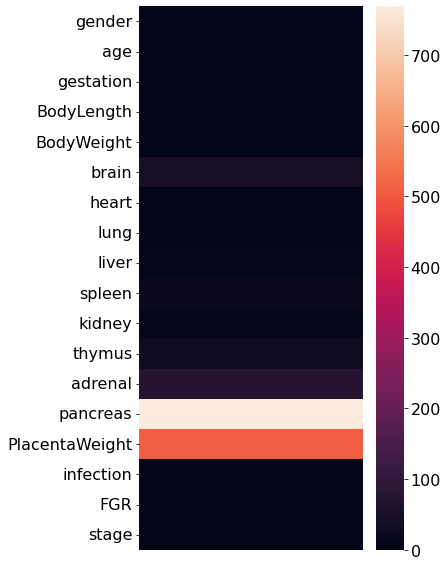

In [911]:
matplotlib.rcParams['figure.figsize'] = [5, 10]
msn_hm = sns.heatmap(pd.DataFrame(source_raw.apply(lambda x: x.isna().sum(), axis=0)))
plt.xticks([])
plt.show()

In [912]:
source_raw['gestation'] = source_raw['gestation'].astype(gestation_series)

In [915]:
source_raw_for_imputation: pd.core.frame.DataFrame = source_raw.iloc[:, :-3]

In [916]:
diff_imps_raw: Dict[str, pd.core.frame.DataFrame] = dict()
train_sample_raw: pd.core.frame.DataFrame = source_raw_for_imputation.sample(frac=0.2)
for strategy in ['mean', 'median', 'most_frequent', 'constant']:
    # imputed: pd.core.frame.DataFrame = pd.DataFrame(
    #     mice(na_outliers.values, initial_strategy=strategy)
    # )
    iterimp: IterativeImputer = IterativeImputer(
        missing_values=np.nan, 
        random_state=42, 
        initial_strategy=strategy, 
        max_iter=20
    )
    iterimp.fit(train_sample_raw.values)
    imputed: pd.core.frame.DataFrame = pd.DataFrame(iterimp.transform(source_raw_for_imputation.values))
    imputed.columns = source_raw_for_imputation.columns
    for col in ['age', 'gender']:
        imputed[col] = pd.Categorical(imputed[col])
    imputed['gestation'] = imputed['gestation'].astype(gestation_series)
    print(f'INITIAL STRATEGY: {strategy}')
    for week in set(source_raw_for_imputation['gestation']).intersection(set(imputed['gestation'])):
        filt_sub: pd.core.series.Series = source_filt[source_filt['gestation'] == week]['BodyWeight']
        imp_sub: pd.core.series.Series = imputed[imputed['gestation'] == week]['BodyWeight']
        if filt_sub.shape[0] >= 10 and imp_sub.shape[0] >= 10:
            print('\t'.join(map(str, [week, 'weight', shapiro(filt_sub)[1], shapiro(imp_sub)[1]])))
        filt_sub: pd.core.series.Series = source_filt[source_filt['gestation'] == week]['BodyLength']
        imp_sub: pd.core.series.Series = imputed[imputed['gestation'] == week]['BodyLength']
        if filt_sub.shape[0] >= 10 and imp_sub.shape[0] >= 10:
            print('\t'.join(map(str, [week, 'length', shapiro(filt_sub)[1], shapiro(imp_sub)[1]])))
    diff_imps_raw[strategy] = imputed

INITIAL STRATEGY: mean
24	weight	0.004688899498432875	1.99753302787542e-09
24	length	7.3310484367539175e-06	6.691772136413476e-12
25	weight	0.012158338911831379	1.5914618956003324e-08
25	length	2.2308345393184936e-08	2.7338830851930673e-11
26	weight	0.35616785287857056	3.132808146233401e-08
26	length	1.5695412002969533e-05	3.095272000388599e-16
27	weight	0.0032945943530648947	1.4910671808365805e-08
27	length	0.0008343503577634692	7.282705688504976e-11
28	weight	0.1684207171201706	0.020898805931210518
28	length	0.007078296504914761	2.119869861871848e-07
29	weight	0.018604131415486336	0.0007376223220489919
29	length	0.006324355024844408	0.0005697704618796706
30	weight	0.21446798741817474	0.0541057325899601
30	length	0.26128119230270386	0.005986141972243786
31	weight	0.20801864564418793	0.8000189661979675
31	length	0.5683104991912842	0.011451274156570435
32	weight	0.005121293943375349	0.6492480635643005
32	length	0.03775330260396004	0.010026962496340275
34	weight	0.20174387097358704	0.000

## Adding the metrics

In [976]:
source_raw_imp: pd.core.frame.DataFrame = diff_imps_raw['mean']

In [977]:
source_raw_imp.index = source_raw.index

In [978]:
source_raw_imp = source_raw_imp.merge(source_raw.iloc[:,-3:], left_index=True, right_index=True)

In [979]:
for col in ['age', 'gender', 'FGR', 'gestation', 'infection', 'stage']:
    source_raw_imp[col] = pd.Categorical(source_raw_imp[col])

In [980]:
source_raw_imp['WLR'] = source_raw_imp['BodyWeight'] / source_raw_imp['BodyLength']

In [933]:
source_raw_imp

,gender,age,gestation,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,kidney,thymus,adrenal,pancreas,PlacentaWeight,infection,FGR,stage,WLR
id,,,,,,,,,,,,,,,,,,,
m2005_2,2.0,0.0,23,29.0,500.0,78.0,4.00,16.20,35.0,2.00,8.10,1.90,2.30,1.00,195.000000,infection,0,canalicular,17.241379
m2005_9,2.0,0.0,37,45.0,2330.0,279.5,12.95,35.75,75.5,6.00,17.70,5.00,5.20,2.70,300.000000,aspiration,0,alveolar,51.777778
m2005_10,2.0,0.0,25,33.0,740.0,96.5,4.30,11.80,22.5,1.20,4.95,1.40,1.55,0.65,150.000000,no,0,canalicular,22.424242
m2005_13,1.0,1.0,36,47.0,2800.0,345.0,19.60,50.00,124.3,9.60,26.00,8.70,7.80,3.20,365.378746,no,0,saccular,59.574468
m2005_15,1.0,0.0,22,28.0,450.0,57.0,2.75,7.50,14.0,0.75,3.45,0.65,0.75,0.45,100.000000,no,0,canalicular,16.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m2014_1103,1.0,0.0,33,42.0,1650.0,366.0,8.89,49.40,50.1,8.00,15.06,6.90,7.10,1.90,254.000000,no,0,saccular,39.285714
m2014_1116,1.0,0.0,22,30.0,560.0,144.0,5.80,18.80,32.4,1.90,7.70,1.30,3.80,0.42,174.000000,no,0,canalicular,18.666667
m2014_1132,1.0,0.0,22,29.0,458.0,76.0,1.70,8.04,23.0,1.33,4.43,0.30,1.80,0.40,102.000000,no,0,canalicular,15.793103


In [981]:
source_raw_imp['BW3'] = source_raw_imp.apply(lambda x: below_centile(x, 'BodyWeight'), axis=1)
source_raw_imp['BL3'] = source_raw_imp.apply(lambda x: below_centile(x, 'BodyLength'), axis=1)
source_raw_imp['WLR3'] = source_raw_imp.apply(lambda x: below_centile(x, 'WLR'), axis=1)

In [982]:
source_raw_imp['BLWR'] = source_raw_imp['brain'] / source_raw_imp['liver']
source_raw_imp['PI'] = (source_raw_imp['BodyWeight'] / source_raw_imp['BodyLength'] ** 3 ) / 100
source_raw_imp['BMI'] = (source_raw_imp['BodyWeight']) / (1000 * source_raw_imp['BodyLength'] ** 2)
source_raw_imp['BSA_Du_Bois'] = (0.007184 * (source_raw_imp['BodyWeight'] ** 0.425) * (source_raw_imp['BodyLength'] ** 0.725)) / 1000
source_raw_imp['BSA_Boyd'] = 4.688 * (source_raw_imp['BodyLength'] ** (0.8168 - 0.0154 * np.log(source_raw_imp['BodyWeight'])))
source_raw_imp['BSA_neo'] = 5.52005 * ((source_raw_imp['BodyWeight'] ** 0.5526) * (source_raw_imp['BodyLength'] ** 0.3800))

In [983]:
source_raw_imp['BrainBody'] = source_raw_imp['brain'] / source_raw_imp['BodyWeight']
source_raw_imp['HeartBody'] = source_raw_imp['brain'] / source_raw_imp['BodyWeight']
source_raw_imp['LungBody'] = source_raw_imp['lung'] / source_raw_imp['BodyWeight']
source_raw_imp['LiverBody'] = source_raw_imp['liver'] / source_raw_imp['BodyWeight']
source_raw_imp['SpleenBody'] = source_raw_imp['spleen'] / source_raw_imp['BodyWeight']
source_raw_imp['KidneyBody'] = source_raw_imp['kidney'] / source_raw_imp['BodyWeight']
source_raw_imp['ThymusBody'] = source_raw_imp['thymus'] / source_raw_imp['BodyWeight']
source_raw_imp['AdrenalBody'] = source_raw_imp['adrenal'] / source_raw_imp['BodyWeight']
source_raw_imp['PancreasBody'] = source_raw_imp['pancreas'] / source_raw_imp['BodyWeight']
source_raw_imp['PlacentaBody'] = source_raw_imp['PlacentaWeight'] / source_raw_imp['BodyWeight']

In [984]:
source_raw_imp['BLWR_FGR'] = source_raw_imp.apply(BLWR_threshold, axis=1)

In [989]:
source_raw_imp['consensual_FGR'] = source_raw_imp['BW3'] + source_raw_imp['BL3'] + source_raw_imp['WLR3']

In [991]:
source_raw_imp['BW3'] = pd.Categorical(source_raw_imp['BW3'])
source_raw_imp['BL3'] = pd.Categorical(source_raw_imp['BL3'])
source_raw_imp['WLR'] = pd.Categorical(source_raw_imp['WLR'])
source_raw_imp['consensual_FGR'] = pd.Categorical(source_raw_imp['consensual_FGR'])

In [992]:
with open(os.path.join('imputed_data', 'raw_with_imputations_and_coefs.csv'), 'w') as h:
    source_raw_imp.to_csv(h, header=True, index=False, sep=',')

## Checking the scores contingency

In [993]:
score_vals: pd.core.frame.DataFrame = pd.DataFrame(
    {
        'Centile-based': source_raw_imp.apply(lambda x: int(x['consensual_FGR'] > 1), axis=1), 
        'BLWR': source_raw_imp['BLWR_FGR']}
)

In [1011]:
source_raw_imp[(source_raw_imp.FGR == 1) & ((source_raw_imp.BLWR_FGR == 1) | (source_raw_imp.consensual_FGR == 2) | (source_raw_imp.consensual_FGR == 3))]

,gender,age,gestation,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,...,LungBody,LiverBody,SpleenBody,KidneyBody,ThymusBody,AdrenalBody,PancreasBody,PlacentaBody,BLWR_FGR,consensual_FGR
id,,,,,,,,,,,,,,,,,,,,,
m2005_155,2.0,0.0,27,26.0,700.0,124.000000,5.000000,16.500000,32.000000,1.400000,...,0.023571,0.045714,0.002000,0.008571,0.001429,0.002286,0.001143,0.160000,1,1.0
m2005_163,1.0,0.0,31,30.0,890.0,141.000000,6.800000,21.600000,40.000000,2.600000,...,0.024270,0.044944,0.002921,0.011124,0.003146,0.003258,0.001334,0.160674,1,2.0
m2006_978,2.0,1.0,38,50.0,2600.0,320.000000,14.100000,42.200000,102.300000,8.100000,...,0.016231,0.039346,0.003115,0.008731,0.004000,0.002577,0.001269,0.131334,1,0.0
m2007_917,2.0,1.0,35,44.0,1980.0,250.000000,12.400000,36.000000,75.500000,6.000000,...,0.018182,0.038131,0.003030,0.006313,0.004899,0.002172,0.000859,0.145485,1,0.0
m2008_73,2.0,0.0,34,38.0,1200.0,170.000000,7.400000,25.000000,49.000000,2.500000,...,0.020833,0.040833,0.002083,0.012333,0.005250,0.002750,0.000833,0.300000,1,2.0
m2008_347,2.0,0.0,36,44.0,1670.0,253.500000,11.400000,31.800000,64.500000,5.300000,...,0.019042,0.038623,0.003174,0.009581,0.003353,0.002934,0.001377,0.147904,1,1.0
m2008_824,1.0,1.0,31,33.0,890.0,134.000000,6.200000,22.000000,33.200000,2.100000,...,0.024719,0.037303,0.002360,0.011573,0.003596,0.002809,0.001011,0.208989,1,2.0
m2009_465,2.0,1.0,38,49.0,2720.0,340.000000,15.300000,66.100000,96.900000,8.800000,...,0.024301,0.035625,0.003235,0.010147,0.005184,0.002206,0.001324,0.130302,1,0.0
m2009_973,2.0,0.0,24,28.0,320.0,67.310249,2.200000,8.100000,12.200000,0.310000,...,0.025312,0.038125,0.000969,0.010625,0.001094,0.002187,0.001104,0.175937,1,2.0


In [998]:
score_vals

,Centile-based,BLWR
id,,
m2005_2,0,0
m2005_9,0,1
m2005_10,0,1
m2005_13,0,0
m2005_15,0,1
...,...,...
m2014_1103,0,1
m2014_1116,0,1
m2014_1132,0,0


In [999]:
pd.crosstab(score_vals['Centile-based'], score_vals['BLWR'])

BLWR,0,1
Centile-based,,
0,2338,759
1,67,105


## Adding class markers

In [1059]:
source_raw_imp['Y'] = source_raw_imp.apply(lambda x: int((x['FGR'] == 1) | ((x['BLWR_FGR'] == 1) & ((x['consensual_FGR'] == 2) | (x['consensual_FGR'] == 3)))), axis=1)

In [1060]:
Counter(source_raw_imp.Y)

Counter({0: 3144, 1: 125})

In [1061]:
intergrowth_gest: pd.core.frame.DataFrame = source_raw_imp[
    ~(source_raw_imp['gestation'].isin(list(range(15, 24))))
]

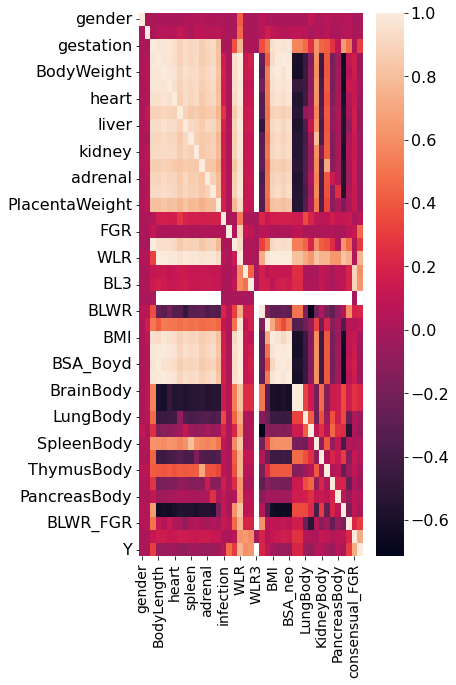

In [1062]:
sns.heatmap(fullCorrmat(intergrowth_gest))
# plt.savefig(
#     os.path.join('source_figs', 'heatmap_corr_filt.png'),
# )
plt.show()

In [1063]:
promising_predictors: List[str] = [
    'gender', 'gestation', 'BodyLength', 
    'BodyWeight', 'PI', 'BMI', 
    'BSA_Du_Bois', 'BSA_Boyd', 'BSA_neo', 
    'BrainBody', 'HeartBody', 'LungBody', 
    'LiverBody', 'SpleenBody', 'KidneyBody', 
    'ThymusBody', 'AdrenalBody', 'PancreasBody',
    'PlacentaBody'
]

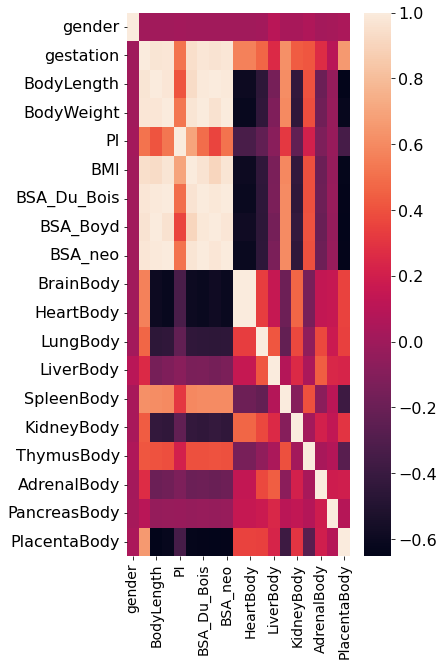

In [1064]:
sns.heatmap(fullCorrmat(intergrowth_gest[promising_predictors]))
# plt.savefig(
#     os.path.join('source_figs', 'heatmap_corr_filt.png'),
# )
plt.show()

In [1065]:
final: pd.core.frame.DataFrame = intergrowth_gest[promising_predictors + ['Y']]

In [1068]:
final['Y'] = pd.Categorical(final['Y'])

In [ ]:
X, y = final.iloc[:, :-1].to_numpy(), final['Y'].to_numpy()

In [1087]:
cv: Callable = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [1081]:
n_jobs: int = 8

In [1089]:
clf = GridSearchCV(
    xgboost.XGBClassifier(random_state=42),
    sg,
    cv=cv,
    n_jobs=n_jobs
)

In [1090]:
clf.fit(X, y)

/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be remove

[00:38:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, s

In [1130]:
clf.best_score_

0.9731517509727625

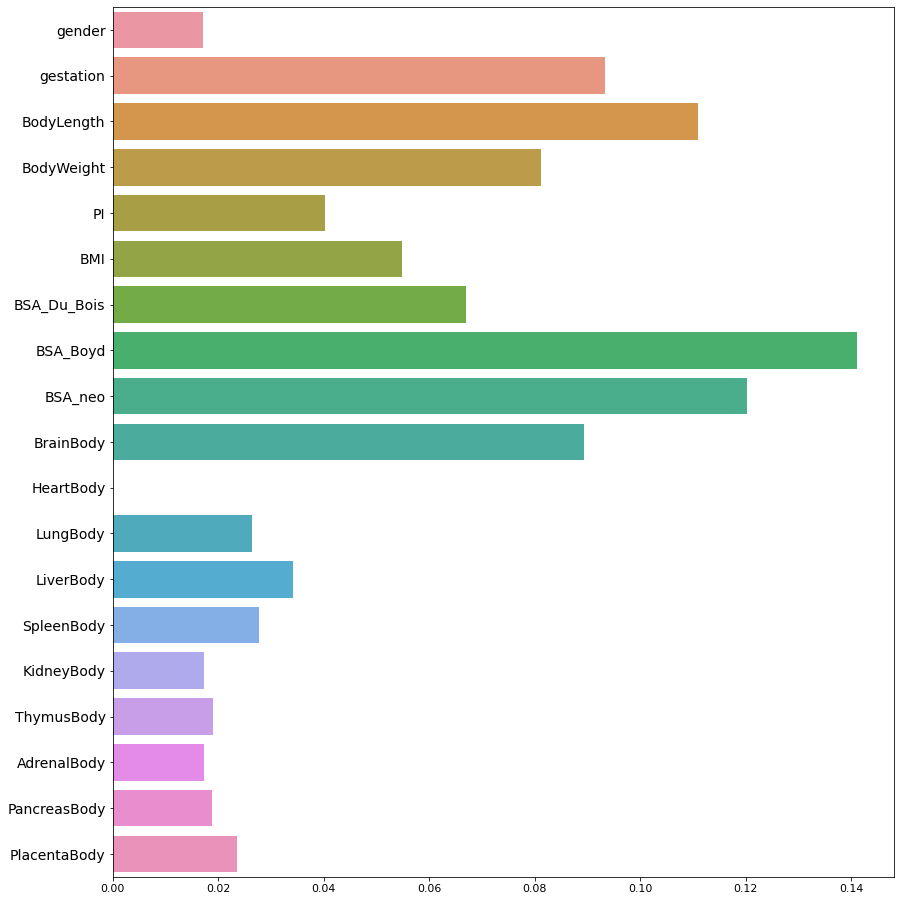

In [1133]:
matplotlib.rcParams['figure.figsize'] = [14, 16]
sns.barplot(
    x=clf.best_estimator_.feature_importances_,
    y=final.columns[:-1]
)
plt.savefig(
    os.path.join('source_figs', 'xgboost_barplot.png'),
)
plt.show()

In [1095]:
clf.best_estimator_.feature_importances_

array([0.01718525, 0.0933233 , 0.11095271, 0.08128743, 0.04027573,
       0.05494742, 0.06692618, 0.14102587, 0.12022516, 0.08929034,
       0.        , 0.02641487, 0.03424719, 0.02776391, 0.01738014,
       0.01906306, 0.01733732, 0.01878132, 0.02357288], dtype=float32)

In [1144]:
best_features: List[str] = [final.columns[x] for x in range(final.shape[1] - 1) if clf.best_estimator_.feature_importances_[x] > 0.04]

In [1145]:
X_b, y_b = final[best_features].to_numpy(), final['Y'].to_numpy()

In [1146]:
clf2 = GridSearchCV(
    xgboost.XGBClassifier(random_state=42),
    sg,
    cv=cv,
    n_jobs=n_jobs
)

In [1147]:
clf2.fit(X_b, y_b)

/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/colonycollapse/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be remove

[09:26:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, s

In [1148]:
clf2.best_score_

0.9735408560311283

In [1150]:
clf.best_score_

0.9731517509727625

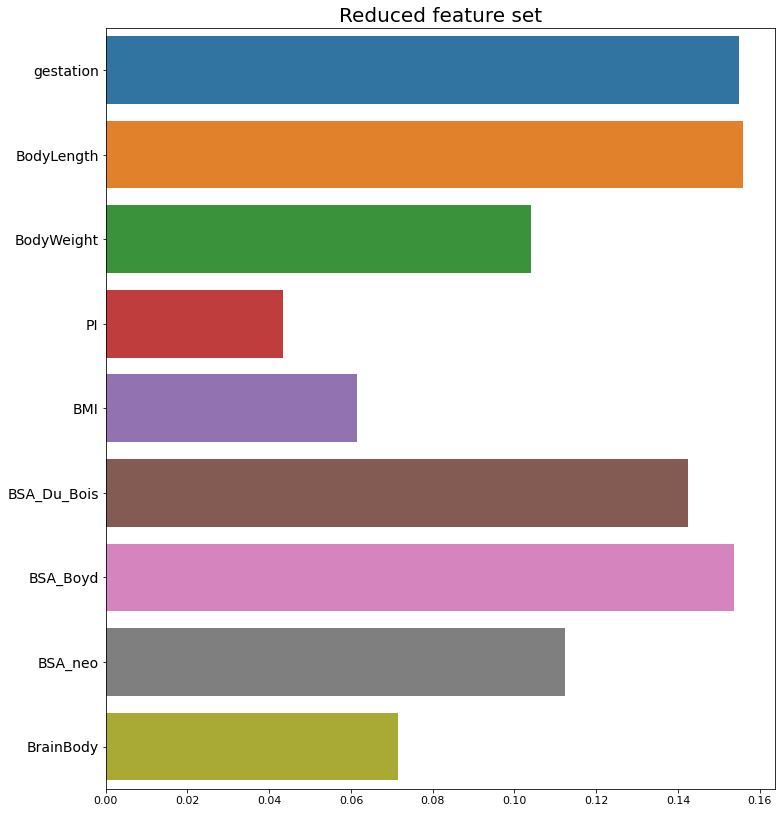

In [1156]:
matplotlib.rcParams['figure.figsize'] = [12, 14]
sns.barplot(
    x=clf2.best_estimator_.feature_importances_,
    y=best_features
)
plt.title('Reduced feature set', size=20)
plt.savefig(
    os.path.join('source_figs', 'xgboost_barplot_reduced.png'),
)
plt.show()

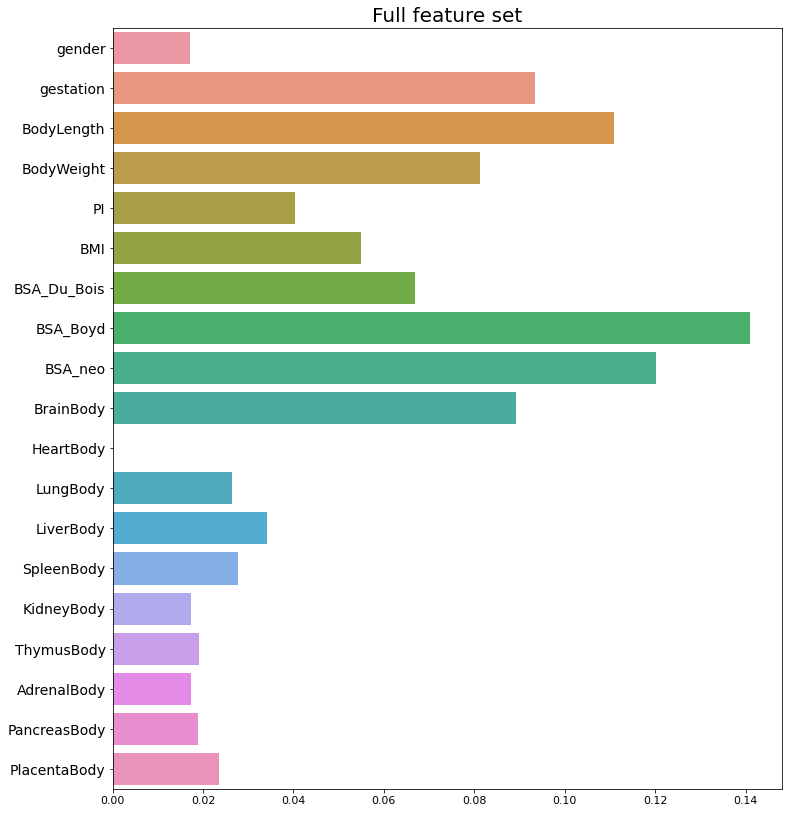

In [1157]:
matplotlib.rcParams['figure.figsize'] = [12, 14]
sns.barplot(
    x=clf.best_estimator_.feature_importances_,
    y=final.columns[:-1]
)
plt.title('Full feature set', size=20)
plt.savefig(
    os.path.join('source_figs', 'xgboost_barplot.png'),
)
plt.show()

In [1158]:
from sklearn import metrics

In [1162]:
init_confusion = init_confusion = metrics.confusion_matrix(y, clf.best_estimator_.predict(X))

In [1163]:
reduced_confusion = metrics.confusion_matrix(y, clf2.best_estimator_.predict(X_b))

In [1166]:
init_confusion

array([[2445,    0],
       [   0,  123]])

In [1167]:
reduced_confusion

array([[2445,    0],
       [   2,  121]])

In [1179]:
init_accuracy = (init_confusion[0][0] + init_confusion[1][1]) / (init_confusion[0][0] + init_confusion[0][1] + init_confusion[1][0] + init_confusion[1][1])

In [1182]:
reduced_accuracy = (reduced_confusion[0][0] + reduced_confusion[1][1]) / (reduced_confusion[0][0] + reduced_confusion[0][1] + reduced_confusion[1][0] + reduced_confusion[1][1])

In [1184]:
init_precision = (init_confusion[1][1]) / (init_confusion[0][1] + init_confusion[1][1])

In [1186]:
reduced_precision = (reduced_confusion[1][1]) / (reduced_confusion[0][1] + reduced_confusion[1][1])

In [1191]:
source_raw.columns

Index(['gender', 'age', 'gestation', 'BodyLength', 'BodyWeight', 'brain',
       'heart', 'lung', 'liver', 'spleen', 'kidney', 'thymus', 'adrenal',
       'pancreas', 'PlacentaWeight', 'infection', 'FGR', 'stage'],
      dtype='object')

In [1194]:
print('\t'.join(['Week', 'Organ', 'Shapiro p-val, boys', 'Shapiro p-val, girls', 'KS p-val, b2g', 't-test p-val, b2g']))
for gest_week in sorted(source_filt['gestation'].unique()):
    for organ in ['BodyWeight', 'BodyLength', 'brain', 'liver', 'heart', 'lung', 'pancreas', 'thymus', 'spleen', 'kidney']:
        boy_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 1)][organ]
        girl_vals: pd.core.series.Series = source_filt[(source_filt['gestation'] == gest_week) & (source_filt['gender'] == 2)][organ]
        if boy_vals.shape[0] >= 10 and girl_vals.shape[0] >= 10:
            boy_norm: float = shapiro(boy_vals)[1]
            girl_norm: float = shapiro(girl_vals)[1]
            b2g_ks: float = ks_2samp(boy_vals, girl_vals)[1]
            b2g_t: float = ttest_ind(boy_vals, girl_vals)[1]
            print('\t'.join(map(str, [gest_week, organ, boy_norm, girl_norm, b2g_ks, b2g_t])))

Week	Organ	Shapiro p-val, boys	Shapiro p-val, girls	KS p-val, b2g	t-test p-val, b2g
24	BodyWeight	0.029016949236392975	0.07878948748111725	0.3626120545446845	0.3181206968709826
24	BodyLength	0.0006210980354808271	0.0005210013478063047	0.9823325684847116	0.3880405318761687
24	brain	0.6331586837768555	0.31784042716026306	0.30081182750407764	0.35364632135576346
24	liver	0.7148619890213013	0.9896621108055115	0.8122203047515213	0.9708557751487548
24	heart	0.17831571400165558	0.7200700640678406	0.7049125010198345	0.13011174697643405
24	lung	0.09074199199676514	0.7208266854286194	0.7049125010198345	0.5596510678839633
24	pancreas	0.025655364617705345	0.09900558739900589	0.9995056225197282	0.9799858582728989
24	thymus	0.21833844482898712	0.3706058859825134	0.8030260749458616	0.46908056776449614
24	spleen	0.3919636607170105	0.20449839532375336	0.8784252651578179	0.5321001327077421
24	kidney	0.21244728565216064	0.15285049378871918	0.9070606917851787	0.6533031920653231
25	BodyWeight	0.358578085899

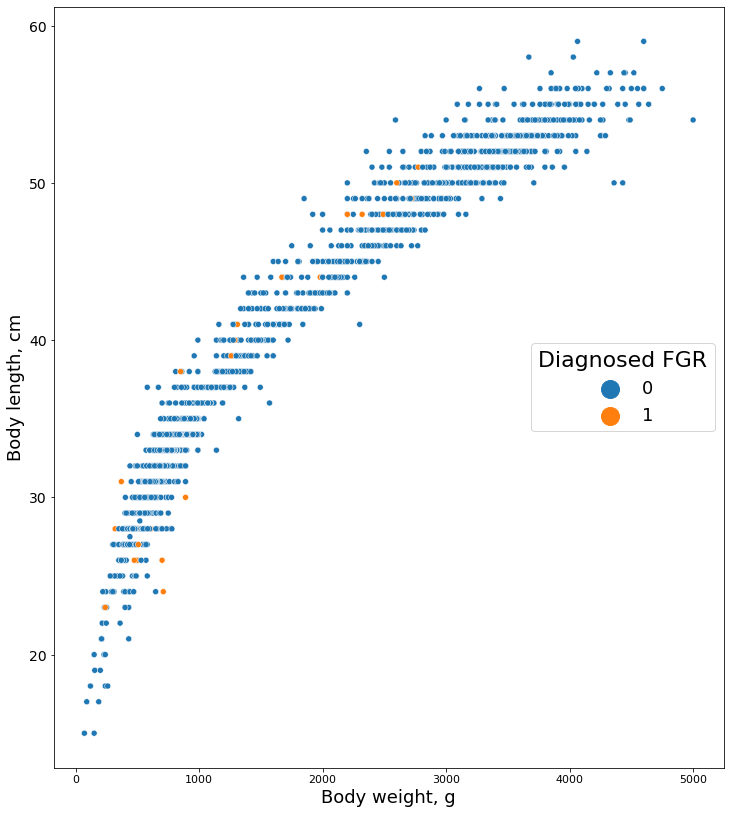

In [1224]:
f1 = sns.scatterplot(
    data=source_raw_imp,
    x='BodyWeight',
    y='BodyLength',
    hue='FGR'
)
f1.set_xlabel('Body weight, g', size=18)
f1.set_ylabel('Body length, cm', size=18)
lgnd = plt.legend(loc='center right', markerscale=3, title='Diagnosed FGR', title_fontsize=22, fontsize=18)
plt.savefig(
    os.path.join('source_figs', 'length_vs_weight.png'),
)
plt.show()

In [1217]:
[x for x in lgnd.__dict__ if x.find('marker') > -1]

['markerscale']

In [1196]:
source_raw_imp

,gender,age,gestation,BodyLength,BodyWeight,brain,heart,lung,liver,spleen,...,LiverBody,SpleenBody,KidneyBody,ThymusBody,AdrenalBody,PancreasBody,PlacentaBody,BLWR_FGR,consensual_FGR,Y
id,,,,,,,,,,,,,,,,,,,,,
m2005_2,2.0,0.0,23,29.0,500.0,78.0,4.00,16.20,35.0,2.00,...,0.070000,0.004000,0.016200,0.003800,0.004600,0.002000,0.390000,0,NaN,0
m2005_9,2.0,0.0,37,45.0,2330.0,279.5,12.95,35.75,75.5,6.00,...,0.032403,0.002575,0.007597,0.002146,0.002232,0.001159,0.128755,1,0.0,0
m2005_10,2.0,0.0,25,33.0,740.0,96.5,4.30,11.80,22.5,1.20,...,0.030405,0.001622,0.006689,0.001892,0.002095,0.000878,0.202703,1,0.0,0
m2005_13,1.0,1.0,36,47.0,2800.0,345.0,19.60,50.00,124.3,9.60,...,0.044393,0.003429,0.009286,0.003107,0.002786,0.001143,0.130492,0,0.0,0
m2005_15,1.0,0.0,22,28.0,450.0,57.0,2.75,7.50,14.0,0.75,...,0.031111,0.001667,0.007667,0.001444,0.001667,0.001000,0.222222,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m2014_1103,1.0,0.0,33,42.0,1650.0,366.0,8.89,49.40,50.1,8.00,...,0.030364,0.004848,0.009127,0.004182,0.004303,0.001152,0.153939,1,0.0,0
m2014_1116,1.0,0.0,22,30.0,560.0,144.0,5.80,18.80,32.4,1.90,...,0.057857,0.003393,0.013750,0.002321,0.006786,0.000750,0.310714,1,NaN,0
m2014_1132,1.0,0.0,22,29.0,458.0,76.0,1.70,8.04,23.0,1.33,...,0.050218,0.002904,0.009672,0.000655,0.003930,0.000873,0.222707,0,NaN,0
